In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pytz
from pytz import common_timezones, all_timezones
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
from datetime import datetime
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
matplotlib.style.use('fivethirtyeight')
matplotlib.style.use('seaborn-talk')

This ipython notebook will illustrate the matching methodology we will use to match patients in the SEER-Medicare linked database. The comparison between patient outcomes between those patients who receive proton beam therapy vs traditional radiation therapy requires as a first step a matching of the two different groups. One method to perform this matching is to use Propensity Score Matching. Here we are going to illustrate a more direct method of matching using KDTrees, a data structure that allows for efficient finding of nearest neighbors in high-dimenional space.


We will illustrate the medthodology by using it in the 
latest release of the SEER data. We will take in the colon cancer patient data, and treat the male and female patients as the treatment and control groups, respectively. We will perform the patient matching and show the overall improvement in coviarate balancing that results. We will then ask two questions: "Are Males or Females more likely to be uninsured?" (A discrete outcome; use Bayesian A/B testing), and "Are Male or Female colon cancer patients more likely to live at higher elevation?" (A question involving distributions; answered by sampling repeatedly from the empirical CDFs for both the treatment and control groups).

In [3]:
import seerhelp

colorectfiles = seerhelp.get_colorectfiles()
colorectfiles

['SEER_1973_2013_TEXTDATA\\incidence\\yr1973_2013.seer9\\COLRECT.TXT',
 'SEER_1973_2013_TEXTDATA\\incidence\\yr1992_2013.sj_la_rg_ak\\COLRECT.TXT',
 'SEER_1973_2013_TEXTDATA\\incidence\\yr2000_2013.ca_ky_lo_nj_ga\\COLRECT.TXT',
 'SEER_1973_2013_TEXTDATA\\incidence\\yr2005.lo_2nd_half\\COLRECT.txt']

In [4]:
dfcolon0 = seerhelp.make_clean_dataframe(colorectfiles[0])

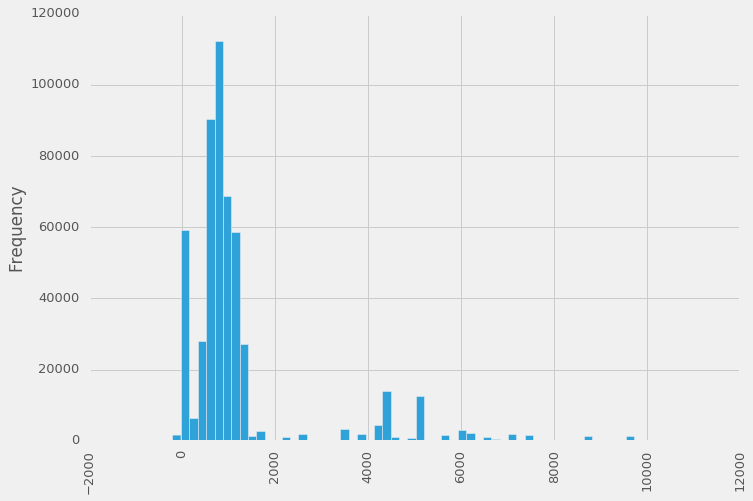

In [6]:
matplotlib.style.use('fivethirtyeight')
dfcolon0['elevation'].plot(kind='hist',bins=60,rot=90);

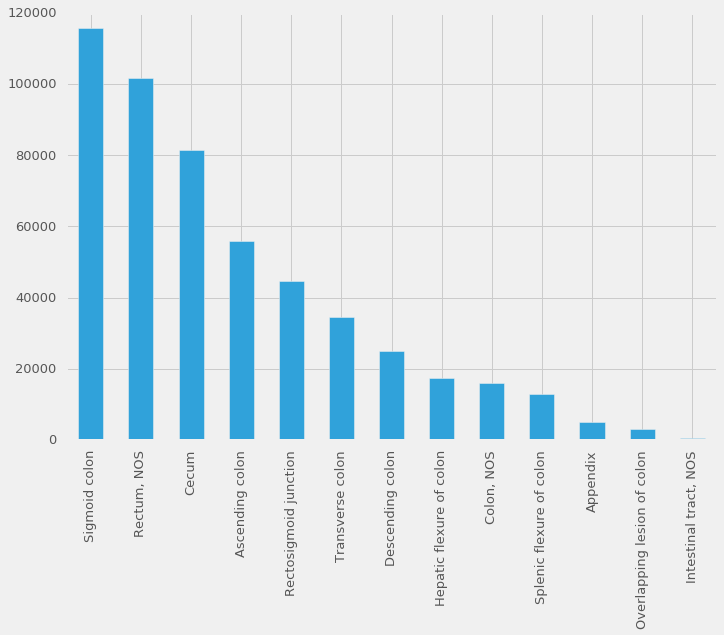

In [7]:
dfcolon0['PRIMSITE'].value_counts().plot(kind='bar',rot=90);


## <font color='purple'>One-Hot Encode the categorical variables we wish to include</font>

In order to find the nearest neighbors in the high-dimensional feature space, we need to first do soem preprocessing of the data. The first step is to "one-hot encode" the categorical features.

In [8]:

mask = (dfcolon0['CSTUMSIZ'] != "Unknown; size not stated; not stated in patient record") & \
 (dfcolon0['CSTUMSIZ'] != "Microscopic focus or foci only; no size of focus is given") & \
 (dfcolon0['CSTUMSIZ'] != "989 millimeters or larger") & \
 (dfcolon0['CSTUMSIZ'] != "Not applicable") & \
 (dfcolon0['AGE_DX'] != "Unknown age") & \
 (dfcolon0['srv_time_mon_flag'] == "Complete dates are available and there are more than 0 days of survival") & \
 (dfcolon0['REC_NO'] == 1) & \
 (dfcolon0['YEAR_DX'] >= 2004) & \
 (dfcolon0['CSTUMSIZ'] != "Described as less than 1 cm") & \
(dfcolon0['CSTUMSIZ'] != "Described as less than 2 cm") & \
(dfcolon0['CSTUMSIZ'] != "Described as less than 3 cm") & \
(dfcolon0['CSTUMSIZ'] != 'Indicates no msas or no tumor found; for example, when a tumor of a stated primary site is not found, but the tumor has metastasized') & \
(dfcolon0['CSTUMSIZ'] != "Described as less than 4 cm") & \
(dfcolon0['CSTUMSIZ'] != "Described as less than 5 cm") & \
(dfcolon0['CSTUMSIZ'] != "Not applicable") & \
(dfcolon0['YR_BRTH'] != 'Unknown year of birth') & \
(dfcolon0['CSTUMSIZ'] != 'Not applicable') & \
(dfcolon0['CSTUMSIZ'] != 996) & \
(dfcolon0['CSTUMSIZ'] != 997) & \
(dfcolon0['CSTUMSIZ'] != 998)

In [9]:
dfsmall = dfcolon0[mask].copy()

In [10]:
dfsmall.set_index('PUBCSNUM',inplace=True)


In [11]:
dfsmall.shape

(74179, 140)

In [12]:
dfsmall.SEX.value_counts()

Male      37606
Female    36573
Name: SEX, dtype: int64

## <font color='purple'>Treatment and Control group definitions</font>

Let's consider ```(dfsmall.SEX == "Male")``` as the **treatment** group and 
```(dfsmall.SEX == "Female")``` as the **control** group. We need to match patients in the tratment group with those in the control group.

In [13]:
catcols = ['SEX','MAR_STAT','RACEIV','NHIADE','GRADE','PRIMSITE',
          'LATERAL','HST_STGA','HISTREC','MDXRECMP','STAT_REC']

goodcols = ['SEX','MAR_STAT','RACEIV','NHIADE','GRADE','PRIMSITE',
          'LATERAL','HST_STGA','HISTREC','MDXRECMP','STAT_REC',
           'YR_BRTH','AGE_DX','YEAR_DX','CSTUMSIZ',
           'lat','lng']


In [14]:
resgood = pd.concat([pd.get_dummies(dfsmall[col],prefix=col) for col in catcols], axis=1)

In [16]:
resgood['YR_BRTH'] = dfsmall['YR_BRTH']
resgood['AGE_DX'] = dfsmall['AGE_DX']#resgood['sequence_number_central'] = dfsmall['sequence_number_central']
resgood['YEAR_DX'] = dfsmall['YEAR_DX']
resgood['CSTUMSIZ'] = dfsmall['CSTUMSIZ']
resgood['lat'] = dfsmall['lat']
resgood['lng'] = dfsmall['lng']
resgood['srv_time_mon'] = dfsmall['srv_time_mon']


print(resgood.shape)

(74179, 115)


In [17]:
resgood['STAT_REC_Dead'].value_counts()

0.0    47051
1.0    27128
Name: STAT_REC_Dead, dtype: int64

After performing the matching between the control and treatment groups, we can see how the kaplan-meier curves differ

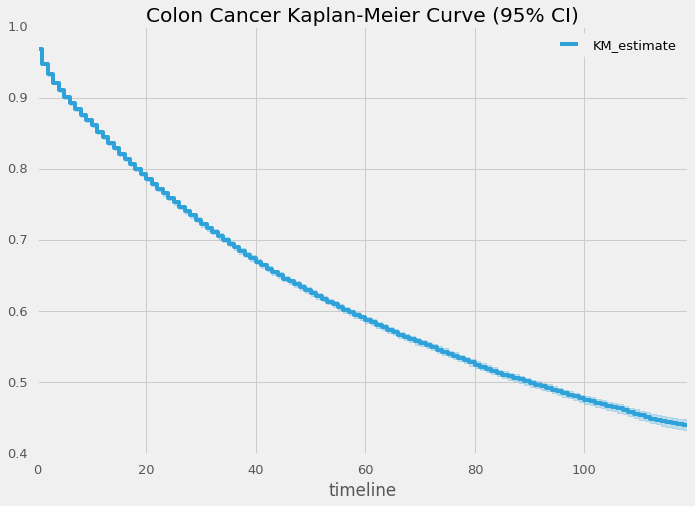

In [18]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()

T = resgood["srv_time_mon"]
E = resgood["STAT_REC_Dead"]

kmf.fit(T, event_observed=E);
kmf.plot()
plt.title("Colon Cancer Kaplan-Meier Curve (95% CI)");

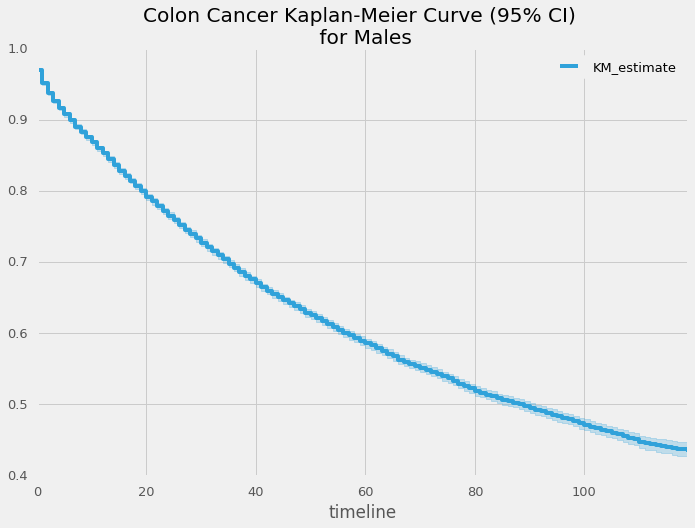

In [19]:
from lifelines import KaplanMeierFitter

kmfmales = KaplanMeierFitter()

T = resgood[resgood.SEX_Male == 1]["srv_time_mon"]
E = resgood[resgood.SEX_Male == 1]["STAT_REC_Dead"]

kmfmales.fit(T, event_observed=E);
kmfmales.plot()
plt.title("Colon Cancer Kaplan-Meier Curve (95% CI) \n for Males");

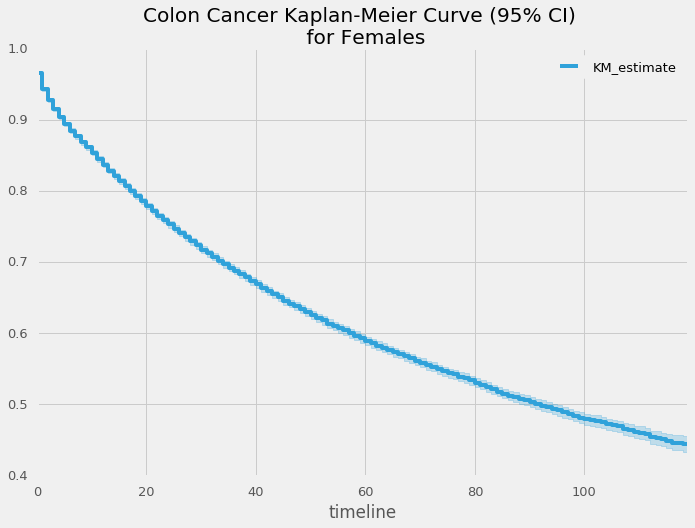

In [20]:
from lifelines import KaplanMeierFitter

kmffemales = KaplanMeierFitter()

T = resgood[resgood.SEX_Male == 0]["srv_time_mon"]
E = resgood[resgood.SEX_Male == 0]["STAT_REC_Dead"]

kmffemales.fit(T, event_observed=E);
kmffemales.plot()
plt.title("Colon Cancer Kaplan-Meier Curve (95% CI) \n for Females");

In [21]:
resgood['YR_BRTH'] = resgood['YR_BRTH'].astype('int')
resgood['AGE_DX'] = resgood['AGE_DX'].astype('int')
resgood['CSTUMSIZ'] = resgood['CSTUMSIZ'].astype('float')
resgood['lat'] = resgood['lat'].astype('float')
resgood['lng'] = resgood['lng'].astype('float')
resgood['srv_time_mon'] = resgood['srv_time_mon'].astype('float')

In [22]:
newcolumns = list(resgood.columns)
list(newcolumns)

['SEX_Female',
 'SEX_Male',
 'MAR_STAT_Divorced',
 'MAR_STAT_Married (including common law)',
 'MAR_STAT_Separated',
 'MAR_STAT_Single (never married)',
 'MAR_STAT_Unknown',
 'MAR_STAT_Unmarried or domestic partner (same sex or opposite sex or unregistered)',
 'MAR_STAT_Widowed',
 'RACEIV_American Indian, Aleutian, Alaska Native or Eskimo (includes all indigenous populations of the Western hemisphere)',
 'RACEIV_Asian Indian',
 'RACEIV_Asian Indian or Pakistani, NOS',
 'RACEIV_Black',
 'RACEIV_Chamorran',
 'RACEIV_Chinese',
 'RACEIV_Fiji Islander',
 'RACEIV_Filipino',
 'RACEIV_Guamanian, NOS',
 'RACEIV_Hawaiian',
 'RACEIV_Hmong',
 'RACEIV_Japanese',
 'RACEIV_Kampuchean (including Khmer and Cambodian)',
 'RACEIV_Korean',
 'RACEIV_Laotian',
 'RACEIV_Melanesian, NOS',
 'RACEIV_Micronesian, NOS',
 'RACEIV_New Guinean',
 'RACEIV_Other',
 'RACEIV_Other Asian, including Asian, NOS and Oriental NOS',
 'RACEIV_Pacific Islander, NOS',
 'RACEIV_Pakistani',
 'RACEIV_Polynesian, NOS',
 'RACEIV_Samo

In [23]:
newcolumns.remove('srv_time_mon')
newcolumns.remove('STAT_REC_Alive')
newcolumns.remove('STAT_REC_Dead')
newcolumns.remove('SEX_Female')

In [24]:
resgreat = resgood[newcolumns].copy()
resgreat.head()

SEX_Male  MAR_STAT_Divorced  \
PUBCSNUM                                
7000298        0.0                0.0   
7000375        0.0                0.0   
7000588        1.0                0.0   
7000592        0.0                0.0   
7000642        0.0                1.0   

          MAR_STAT_Married (including common law)  MAR_STAT_Separated  \
PUBCSNUM                                                                
7000298                                       0.0                 0.0   
7000375                                       0.0                 0.0   
7000588                                       1.0                 0.0   
7000592                                       1.0                 0.0   
7000642                                       0.0                 0.0   

          MAR_STAT_Single (never married)  MAR_STAT_Unknown  \
PUBCSNUM                                                      
7000298                               0.0               0.0   
7000375                               0.0               0.0   
7000588                               0.0               0.0   
7000592                               0.0               0.0   
7000642                               0.0               0.0   

          MAR_STAT_Unmarried or domestic partner (same sex or opposite sex or unregistered)  \
PUBCSNUM                                                                                      
7000298                                                 0.0                                   
7000375                                                 0.0                                   
7000588                                                 0.0                                   
7000592                                                 0.0                                   
7000642                                                 0.0                                   

          MAR_STAT_Widowed  \
PUBCSNUM                     
7000298                1.0   
7000375                1.0   
7000588                0.0   
7000592                0.0   
7000642                0.0   

          RACEIV_American Indian, Aleutian, Alaska Native or Eskimo (includes all indigenous populations of the Western hemisphere)  \
PUBCSNUM                                                                                                                              
7000298                                                 0.0                                                                           
7000375                                                 0.0                                                                           
7000588                                                 0.0                                                                           
7000592                                                 0.0                                                                           
7000642                                                 0.0                                                                           

          RACEIV_Asian Indian    ...      MDXRECMP_May  MDXRECMP_Nov  \
PUBCSNUM                         ...                                   
7000298                   0.0    ...               0.0           0.0   
7000375                   0.0    ...               0.0           0.0   
7000588                   0.0    ...               0.0           0.0   
7000592                   0.0    ...               1.0           0.0   
7000642                   0.0    ...               1.0           0.0   

          MDXRECMP_Oct  MDXRECMP_Sep  YR_BRTH  AGE_DX  YEAR_DX  CSTUMSIZ  \
PUBCSNUM                                                                   
7000298            0.0           1.0     1926      86     2012       8.0   
7000375            0.0           0.0     1918      88     2006      75.0   
7000588            1.0           0.0     1921      83     2004      55.0   
7000592            0.0           0.0     1927      83     20

In [25]:
resgreat['League'] = resgreat['SEX_Male']
resgreat.head()

SEX_Male  MAR_STAT_Divorced  \
PUBCSNUM                                
7000298        0.0                0.0   
7000375        0.0                0.0   
7000588        1.0                0.0   
7000592        0.0                0.0   
7000642        0.0                1.0   

          MAR_STAT_Married (including common law)  MAR_STAT_Separated  \
PUBCSNUM                                                                
7000298                                       0.0                 0.0   
7000375                                       0.0                 0.0   
7000588                                       1.0                 0.0   
7000592                                       1.0                 0.0   
7000642                                       0.0                 0.0   

          MAR_STAT_Single (never married)  MAR_STAT_Unknown  \
PUBCSNUM                                                      
7000298                               0.0               0.0   
7000375                               0.0               0.0   
7000588                               0.0               0.0   
7000592                               0.0               0.0   
7000642                               0.0               0.0   

          MAR_STAT_Unmarried or domestic partner (same sex or opposite sex or unregistered)  \
PUBCSNUM                                                                                      
7000298                                                 0.0                                   
7000375                                                 0.0                                   
7000588                                                 0.0                                   
7000592                                                 0.0                                   
7000642                                                 0.0                                   

          MAR_STAT_Widowed  \
PUBCSNUM                     
7000298                1.0   
7000375                1.0   
7000588                0.0   
7000592                0.0   
7000642                0.0   

          RACEIV_American Indian, Aleutian, Alaska Native or Eskimo (includes all indigenous populations of the Western hemisphere)  \
PUBCSNUM                                                                                                                              
7000298                                                 0.0                                                                           
7000375                                                 0.0                                                                           
7000588                                                 0.0                                                                           
7000592                                                 0.0                                                                           
7000642                                                 0.0                                                                           

          RACEIV_Asian Indian   ...    MDXRECMP_Nov  MDXRECMP_Oct  \
PUBCSNUM                        ...                                 
7000298                   0.0   ...             0.0           0.0   
7000375                   0.0   ...             0.0           0.0   
7000588                   0.0   ...             0.0           1.0   
7000592                   0.0   ...             0.0           0.0   
7000642                   0.0   ...             0.0           0.0   

          MDXRECMP_Sep  YR_BRTH  AGE_DX  YEAR_DX  CSTUMSIZ        lat  \
PUBCSNUM                                                                
7000298            1.0     1926      86     2012       8.0  41.326691   
7000375            0.0     1918      88     2006      75.0  41.518519   
7000588            0.0     1921      83     2004      55.0  41.469851   
7000592            0.0     1927      83     2010      40.0  41.792434   
7000642            0.0 

In [26]:
del resgreat['SEX_Male']
resgreat.head()

MAR_STAT_Divorced  MAR_STAT_Married (including common law)  \
PUBCSNUM                                                               
7000298                 0.0                                      0.0   
7000375                 0.0                                      0.0   
7000588                 0.0                                      1.0   
7000592                 0.0                                      1.0   
7000642                 1.0                                      0.0   

          MAR_STAT_Separated  MAR_STAT_Single (never married)  \
PUBCSNUM                                                        
7000298                  0.0                              0.0   
7000375                  0.0                              0.0   
7000588                  0.0                              0.0   
7000592                  0.0                              0.0   
7000642                  0.0                              0.0   

          MAR_STAT_Unknown  \
PUBCSNUM                     
7000298                0.0   
7000375                0.0   
7000588                0.0   
7000592                0.0   
7000642                0.0   

          MAR_STAT_Unmarried or domestic partner (same sex or opposite sex or unregistered)  \
PUBCSNUM                                                                                      
7000298                                                 0.0                                   
7000375                                                 0.0                                   
7000588                                                 0.0                                   
7000592                                                 0.0                                   
7000642                                                 0.0                                   

          MAR_STAT_Widowed  \
PUBCSNUM                     
7000298                1.0   
7000375                1.0   
7000588                0.0   
7000592                0.0   
7000642                0.0   

          RACEIV_American Indian, Aleutian, Alaska Native or Eskimo (includes all indigenous populations of the Western hemisphere)  \
PUBCSNUM                                                                                                                              
7000298                                                 0.0                                                                           
7000375                                                 0.0                                                                           
7000588                                                 0.0                                                                           
7000592                                                 0.0                                                                           
7000642                                                 0.0                                                                           

          RACEIV_Asian Indian  RACEIV_Asian Indian or Pakistani, NOS   ...    \
PUBCSNUM                                                               ...     
7000298                   0.0                                    0.0   ...     
7000375                   0.0                                    0.0   ...     
7000588                   0.0                                    0.0   ...     
7000592                   0.0                                    0.0   ...     
7000642                   0.0                                    0.0   ...     

          MDXRECMP_Nov  MDXRECMP_Oct  MDXRECMP_Sep  YR_BRTH  AGE_DX  YEAR_DX  \
PUBCSNUM                                                                       
7000298            0.0           0.0           1.0     1926      86     2012   
7000375            0.0           0.0           0.0     1918      88     2006   
7000588            0.0           1.0           0.0     1921      83     2004   
7000592            0.0           0.0           0.0    

In [27]:
dftree = resgreat.copy()
dftree.columns


Index(['MAR_STAT_Divorced', 'MAR_STAT_Married (including common law)',
       'MAR_STAT_Separated', 'MAR_STAT_Single (never married)',
       'MAR_STAT_Unknown',
       'MAR_STAT_Unmarried or domestic partner (same sex or opposite sex or unregistered)',
       'MAR_STAT_Widowed',
       'RACEIV_American Indian, Aleutian, Alaska Native or Eskimo (includes all indigenous populations of the Western hemisphere)',
       'RACEIV_Asian Indian', 'RACEIV_Asian Indian or Pakistani, NOS',
       ...
       'MDXRECMP_Nov', 'MDXRECMP_Oct', 'MDXRECMP_Sep', 'YR_BRTH', 'AGE_DX',
       'YEAR_DX', 'CSTUMSIZ', 'lat', 'lng', 'League'],
      dtype='object', length=111)

In [28]:
y = dftree['League'].copy()
del dftree['League']

In [29]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.multiclass import OneVsRestClassifier

import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plot
#import psycopg2
import random
from sklearn import ensemble
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.cross_validation import StratifiedShuffleSplit
import pylab as plot
from pandas import DataFrame, Series
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn import feature_extraction
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import ParameterGrid
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
#from sklearn.neural_network import MultilayerPerceptronClassifier
from sklearn.neural_network import BernoulliRBM
from sklearn.svm import SVC
import pylab as pl
from sklearn.decomposition import RandomizedPCA
from itertools import cycle
from sklearn.cross_validation import ShuffleSplit
from scipy.stats import sem
from pprint import pprint
from math import sqrt, fabs, exp
import matplotlib.pyplot as plot
from sklearn.cross_validation import train_test_split
from sklearn import ensemble
from sklearn.metrics import roc_auc_score, roc_curve
import numpy
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from pandas.tools.plotting import lag_plot

This brute=force method of finding similar matches in this high-dimensional space is possible for this data set as well as for Big Data sized data sets thanks to a data structure called a KDTree. We need to first transform the numeric data so that all of the different features contribute equally to the euclidean distance between records.

For example, **AGE_DX** is on the order of 60 or so, while **YR_BRTH** is around 1960. Without standardization, **YR_BRTH** would contribute much more heavily to the distance between teams than **AGE_DX**. The result of standardization (or Z-score normalization) is that the features will be rescaled so that they will have the properties of a standard normal distribution with

$
\mu = 0 \mbox{ and } \sigma = 1
$

where $\mu$ is the mean (average) and $\sigma$ is the standard deviation from the mean; standard deviation scores (also called $z$ scores are then calculated as follows:

$
z = \frac{x - \mu}{\sigma}
$

In [30]:
xTrain = dftree.values
xTrain = StandardScaler().fit_transform(xTrain)
from sklearn.neighbors import KDTree
print(xTrain)

[[-0.32429901 -1.06912797 -0.08768614 ..., -1.16203921  0.29255123
   1.28299747]
 [-0.32429901 -1.06912797 -0.08768614 ...,  0.92284479  0.32262479
   1.31521769]
 [-0.32429901  0.93534173 -0.08768614 ...,  0.30049136  0.31499487
   1.29708261]
 ..., 
 [-0.32429901 -1.06912797 -0.08768614 ...,  0.54943273 -0.88690371
   0.78990968]
 [-0.32429901  0.93534173 -0.08768614 ..., -1.37986292 -0.87176984
   0.78276799]
 [-0.32429901 -1.06912797 -0.08768614 ..., -0.78862715 -0.86876988
   0.80605294]]


In [31]:
from sklearn.neighbors import KDTree
kdt = KDTree(xTrain, leaf_size=30)



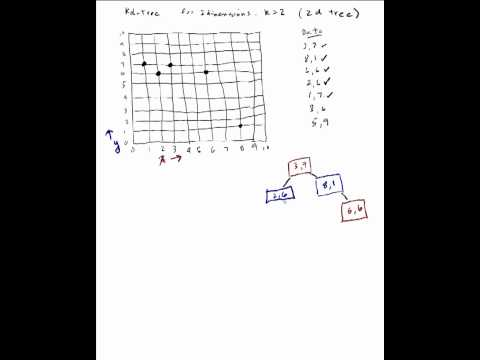

In [34]:
from IPython.display import YouTubeVideo
YouTubeVideo('LdaL-l2S76c')

In [35]:
xTrain.shape

(74179, 110)

In [36]:
dftreeleague = dftree.copy()
dftreeleague['League'] = y
dftreeleague.head()

MAR_STAT_Divorced  MAR_STAT_Married (including common law)  \
PUBCSNUM                                                               
7000298                 0.0                                      0.0   
7000375                 0.0                                      0.0   
7000588                 0.0                                      1.0   
7000592                 0.0                                      1.0   
7000642                 1.0                                      0.0   

          MAR_STAT_Separated  MAR_STAT_Single (never married)  \
PUBCSNUM                                                        
7000298                  0.0                              0.0   
7000375                  0.0                              0.0   
7000588                  0.0                              0.0   
7000592                  0.0                              0.0   
7000642                  0.0                              0.0   

          MAR_STAT_Unknown  \
PUBCSNUM                     
7000298                0.0   
7000375                0.0   
7000588                0.0   
7000592                0.0   
7000642                0.0   

          MAR_STAT_Unmarried or domestic partner (same sex or opposite sex or unregistered)  \
PUBCSNUM                                                                                      
7000298                                                 0.0                                   
7000375                                                 0.0                                   
7000588                                                 0.0                                   
7000592                                                 0.0                                   
7000642                                                 0.0                                   

          MAR_STAT_Widowed  \
PUBCSNUM                     
7000298                1.0   
7000375                1.0   
7000588                0.0   
7000592                0.0   
7000642                0.0   

          RACEIV_American Indian, Aleutian, Alaska Native or Eskimo (includes all indigenous populations of the Western hemisphere)  \
PUBCSNUM                                                                                                                              
7000298                                                 0.0                                                                           
7000375                                                 0.0                                                                           
7000588                                                 0.0                                                                           
7000592                                                 0.0                                                                           
7000642                                                 0.0                                                                           

          RACEIV_Asian Indian  RACEIV_Asian Indian or Pakistani, NOS   ...    \
PUBCSNUM                                                               ...     
7000298                   0.0                                    0.0   ...     
7000375                   0.0                                    0.0   ...     
7000588                   0.0                                    0.0   ...     
7000592                   0.0                                    0.0   ...     
7000642                   0.0                                    0.0   ...     

          MDXRECMP_Nov  MDXRECMP_Oct  MDXRECMP_Sep  YR_BRTH  AGE_DX  YEAR_DX  \
PUBCSNUM                                                                       
7000298            0.0           0.0           1.0     1926      86     2012   
7000375            0.0           0.0           0.0     1918      88     2006   
7000588            0.0           1.0           0.0     1921      83     2004   
7000592            0.0           0.0           0.0    

In [37]:
dftreeleague.index


Int64Index([ 7000298,  7000375,  7000588,  7000592,  7000642,  7004906,
             7005056,  7005683,  7005947,  7006067,
            ...
            41901779, 41901987, 41902670, 41903035, 41903131, 41904669,
            41906067, 41906114, 41907180, 41907419],
           dtype='int64', name='PUBCSNUM', length=74179)

In [38]:
def get_league(x):
    return dftreeleague['League'].loc[x]

In [39]:

dist4, ind4 = kdt.query(xTrain, k=4, return_distance=True)

In [40]:
ind4

array([[    0, 21883,  7711,  7028],
       [    1, 29039, 28705, 18289],
       [    2, 67587, 14547, 52084],
       ..., 
       [74176, 16858, 17377, 16203],
       [74177, 13804, 73738, 10405],
       [74178,  4557,  4919, 22393]], dtype=int64)

In [41]:
dist4

array([[ 0.        ,  0.97899529,  1.24425338,  2.08480603],
       [ 0.        ,  1.24949573,  1.89218631,  1.970853  ],
       [ 0.        ,  1.58932491,  1.77197848,  1.95381818],
       ..., 
       [ 0.        ,  4.51652665,  4.82091597,  4.8296084 ],
       [ 0.        ,  2.54275725,  4.169544  ,  4.39731272],
       [ 0.        ,  2.06829677,  4.42039367,  5.20940814]])

In [42]:
dftreeleague['nearest'] = pd.Series(ind4[:,0],index=dftreeleague.index)
dftreeleague['neighbor_1'] = pd.Series(ind4[:,1],index=dftreeleague.index)
dftreeleague['neighbor_2'] = pd.Series(ind4[:,2],index=dftreeleague.index)
dftreeleague['neighbor_3'] = pd.Series(ind4[:,3],index=dftreeleague.index)
dftreeleague['distance_1'] = pd.Series(dist4[:,1],index=dftreeleague.index)
dftreeleague['distance_2'] = pd.Series(dist4[:,2],index=dftreeleague.index)
dftreeleague['distance_3'] = pd.Series(dist4[:,3],index=dftreeleague.index)

In [43]:
dfmap = {v: dftreeleague.index[v] for v in range(dftreeleague.shape[0])}
dfmap

{0: 7000298,
 1: 7000375,
 2: 7000588,
 3: 7000592,
 4: 7000642,
 5: 7004906,
 6: 7005056,
 7: 7005683,
 8: 7005947,
 9: 7006067,
 10: 7006721,
 11: 7007761,
 12: 7008049,
 13: 7008219,
 14: 7008238,
 15: 7008453,
 16: 7008713,
 17: 7008828,
 18: 7009334,
 19: 7009592,
 20: 7010087,
 21: 7010286,
 22: 7010595,
 23: 7010773,
 24: 7010908,
 25: 7011647,
 26: 7011676,
 27: 7011854,
 28: 7012039,
 29: 7012356,
 30: 7012613,
 31: 7012646,
 32: 7013099,
 33: 7013272,
 34: 7013341,
 35: 7013710,
 36: 7013789,
 37: 7013820,
 38: 7013859,
 39: 7013954,
 40: 7014341,
 41: 7014584,
 42: 7014877,
 43: 7015246,
 44: 7015300,
 45: 7015373,
 46: 7015754,
 47: 7016124,
 48: 7016343,
 49: 7016417,
 50: 7016598,
 51: 7016721,
 52: 7017058,
 53: 7017442,
 54: 7017521,
 55: 7018167,
 56: 7018394,
 57: 7018657,
 58: 7019295,
 59: 7019358,
 60: 7019381,
 61: 7019486,
 62: 7019909,
 63: 7019992,
 64: 7020001,
 65: 7020210,
 66: 7020656,
 67: 7020710,
 68: 7020843,
 69: 7021258,
 70: 7021925,
 71: 7022001,
 7

In [44]:
len(dfmap)

74179

In [45]:
dftreeleague.shape

(74179, 118)

In [46]:
dftreeleague[['neighbor_1','neighbor_2','neighbor_3']].head()


neighbor_1  neighbor_2  neighbor_3
PUBCSNUM                                    
7000298        21883        7711        7028
7000375        29039       28705       18289
7000588        67587       14547       52084
7000592        30624       16130       15389
7000642        28680       72734       32346

## <font color='purple'>Results of the Distance Calculations</font>

In [47]:
dftreeleague[['neighbor_1','distance_1',
        'neighbor_2','distance_2',
        'neighbor_3','distance_3']].head(15)


neighbor_1  distance_1  neighbor_2  distance_2  neighbor_3  \
PUBCSNUM                                                               
7000298        21883    0.978995        7711    1.244253        7028   
7000375        29039    1.249496       28705    1.892186       18289   
7000588        67587    1.589325       14547    1.771978       52084   
7000592        30624    1.088393       16130    1.232478       15389   
7000642        28680    3.660068       72734    3.683505       32346   
7004906        10847    1.447264       28271    2.270245       29063   
7005056         7323    0.721480       30436    1.316821       13819   
7005683        28224    0.986085       17966    1.214874         707   
7005947        18508    0.573807        9486    0.958554        5847   
7006067         7157    0.788149        8448    0.928026       19661   
7006721          745    1.091094        3480    1.361953        4843   
7007761         7756    0.616848       16942    0.664410       32623   
7008049         4400    1.212747       59072    2.473771        1074   
7008219        32452    1.129214        5842    1.168655       31335   
7008238        72796    6.323209        9331    6.394737       72949   

          distance_3  
PUBCSNUM              
7000298     2.084806  
7000375     1.970853  
7000588     1.953818  
7000592     1.288426  
7000642     3.787257  
7004906     2.820125  
7005056     1.414315  
7005683     1.266642  
7005947     1.147024  
7006067     1.239688  
7006721     1.514725  
7007761     0.923040  
7008049     2.544261  
7008219     1.191919  
7008238     6.706042

In [48]:
dftreeleague[['neighbor_1','distance_1',
        'neighbor_2','distance_2',
        'neighbor_3','distance_3']].tail(15)

neighbor_1  distance_1  neighbor_2  distance_2  neighbor_3  \
PUBCSNUM                                                               
41899442       37993    1.467263       28855    1.776080       22291   
41899502       47942    3.898685       69386    4.126234       15814   
41901511       64727    6.952566       16474    7.161436       48561   
41901761       68067    6.162519       21432    6.657077        4146   
41901767       49227    5.624387       53998    5.814779       68398   
41901779       73833    1.615444       18131    1.800406       17544   
41901987       49794    9.352631        6345   11.231654       68299   
41902670       74155    4.035828       32870    4.206543       71541   
41903035       71921    0.952854       32652    1.548629       32811   
41903131       61855    3.182633       16060    3.201651       10440   
41904669        8761    1.447359        6910    2.312507       52440   
41906067       72353    3.460481       16077    3.894419        4817   
41906114       16858    4.516527       17377    4.820916       16203   
41907180       13804    2.542757       73738    4.169544       10405   
41907419        4557    2.068297        4919    4.420394       22393   

          distance_3  
PUBCSNUM              
41899442    1.797951  
41899502    4.152055  
41901511    7.885373  
41901761    7.309041  
41901767    5.895783  
41901779    2.300925  
41901987   11.770198  
41902670    5.413244  
41903035    1.593396  
41903131    3.313945  
41904669    2.364318  
41906067    4.014627  
41906114    4.829608  
41907180    4.397313  
41907419    5.209408

In [49]:
def get_pubcsnum(x,transformationdict = dfmap):
    return dfmap[x]

In [50]:

dftreeleague['neighbor_1'] = dftreeleague['neighbor_1'].apply(get_pubcsnum)
dftreeleague['neighbor_2'] = dftreeleague['neighbor_2'].apply(get_pubcsnum)
dftreeleague['neighbor_3'] = dftreeleague['neighbor_3'].apply(get_pubcsnum)

In [51]:
dftreeleague[['neighbor_1','distance_1',
        'neighbor_2','distance_2',
        'neighbor_3','distance_3']].head(15)

neighbor_1  distance_1  neighbor_2  distance_2  neighbor_3  \
PUBCSNUM                                                               
7000298     20046743    0.978995    12929882    1.244253    12905496   
7000375     27839215    1.249496    27828300    1.892186    19914007   
7000588     41051501    1.589325    18876198    1.771978    39099907   
7000592     27888231    1.088393    19837143    1.232478    18903757   
7000642     27828177    3.660068    41833007    3.683505    27936583   
7004906     18709902    1.447264    27814518    2.270245    27839531   
7005056     12916021    0.721480    27881958    1.316821    18849765   
7005683     27813610    0.986085    19901799    1.214874    11752806   
7005947     19922306    0.573807    12995637    0.958554    12863103   
7006067     12909924    0.788149    12957801    0.928026    19965479   
7006721     11753705    1.091094    11836213    1.361953    11885086   
7007761     12931124    0.616848    19867813    0.664410    27944793   
7008049     11868252    1.212747    35780949    2.473771    11758885   
7008219     27938951    1.129214    12862955    1.168655    27894559   
7008238     41835092    6.323209    12990148    6.394737    41838986   

          distance_3  
PUBCSNUM              
7000298     2.084806  
7000375     1.970853  
7000588     1.953818  
7000592     1.288426  
7000642     3.787257  
7004906     2.820125  
7005056     1.414315  
7005683     1.266642  
7005947     1.147024  
7006067     1.239688  
7006721     1.514725  
7007761     0.923040  
7008049     2.544261  
7008219     1.191919  
7008238     6.706042

In [52]:
def get_league(x):
    return dftreeleague['League'].loc[x]

In [53]:
dftreeleague['neighbor_1_League'] = dftreeleague['neighbor_1'].apply(get_league)
dftreeleague['neighbor_2_League'] = dftreeleague['neighbor_2'].apply(get_league)
dftreeleague['neighbor_3_League'] = dftreeleague['neighbor_3'].apply(get_league)

neighbor_1_match = (dftreeleague['neighbor_1_League'] == 0)

one = dftreeleague[['neighbor_1','distance_1',
                  'neighbor_1_League'
        ]][(dftreeleague['neighbor_1_League'] != dftreeleague['League']) & (neighbor_1_match) ].copy()


neighbor_2_match = (dftreeleague['neighbor_2_League'] == 0)

two = dftreeleague[['neighbor_2','distance_2',
                  'neighbor_2_League'
        ]][(dftreeleague['neighbor_2_League'] != dftreeleague['League']) & (neighbor_2_match) ].copy()


neighbor_3_match = (dftreeleague['neighbor_3_League'] == 0)

three = dftreeleague[['neighbor_3','distance_3',
                  'neighbor_3_League'
        ]][(dftreeleague['neighbor_3_League'] != dftreeleague['League']) & (neighbor_3_match) ].copy()

one

neighbor_1  distance_1  neighbor_1_League
PUBCSNUM                                           
7000588     41051501    1.589325                0.0
7005056     12916021    0.721480                0.0
7005947     19922306    0.573807                0.0
7009334     18824686    0.962108                0.0
7012039     27805611    1.279427                0.0
7016598     11797951    1.578135                0.0
7019295     12975133    3.158819                0.0
7019909     11806818    0.476467                0.0
7023140     27986907    3.492529                0.0
8228375     19914176    0.912898                0.0
10574794    19994196    4.133465                0.0
10594965    15289433    0.801266                0.0
10650500     6152290    5.840590                0.0
11682700    39179115    1.990061                0.0
11701826    11843418    1.314994                0.0
11701839    19918506    4.960101                0.0
11701842    18810483    6.427581                0.0
11701926    27890201    2.766726                0.0
11701945    18784214    0.648397                0.0
11702661    41677194    1.877793                0.0
11702964    27888897    8.266929                0.0
11730710    27813643    4.357078                0.0
11730866    27819512    1.913692                0.0
11731444    11743924    0.247686                0.0
11731530    11748696    1.444660                0.0
11731545    27859811    2.461021                0.0
11731730    18871697    1.069469                0.0
11732239    41736436    1.975040                0.0
11732251    11779681    0.476467                0.0
11732287    27866695    2.700736                0.0
...              ...         ...                ...
41878660    27998410    3.751613                0.0
41878735    27966059    1.695617                0.0
41879117    19849472    6.481040                0.0
41879145    41848487    3.783873                0.0
41879668    39214760    1.617484                0.0
41880019     6167527    4.525066                0.0
41880023    19974237    4.247097                0.0
41880024    28001676    1.565555                0.0
41880553    18886775    6.164776                0.0
41880702     6197885    1.855602                0.0
41881273    41814539    5.287991                0.0
41881558    13017768    1.777566                0.0
41881970    11851397    5.450927                0.0
41882430    41790885    1.564106                0.0
41882781    11835066    7.497902                0.0
41883021    12902507    2.299225                0.0
41883172    39197182    1.604274                0.0
41883461    19930845    4.691826                0.0
41883622    19870863    3.790577                0.0
41884304    41874123    0.925188                0.0
41884797    41740294    2.691251                0.0
41885189    27938130    1.652302                0.0
41885317    20041767    3.737874                0.0
41886898    41809681    3.506220                0.0
41887449    19993411    2.073576                0.0
41887494    41054145    2.948382                0.0
41887856    41773302    1.801256                0.0
41889905    41805985    5.647139                0.0
41893967    41873558    1.053586                0.0
41902670    41888636    4.035828                0.0

[16677 rows x 3 columns]

In [54]:

onedict = one['neighbor_1'].to_dict()
twodict = two['neighbor_2'].to_dict()
threedict = three['neighbor_3'].to_dict()

from collections import defaultdict

dd = defaultdict(list)

for d in (onedict, twodict):
    for key, value in d.items():
        dd[key].append(value)

In [55]:
goodmaleteams = list(dd.keys())

## <font color='purple'>Results of Matching</font>

Looking at only the two closest neighbors and mathhing male patients to any female patients that qualify as being one of the two nearest neighbors, we arrive at the following sets of patients:

In [56]:
goodfemaleteams = list(dd.values())
matches = list(set([item for sublist in goodfemaleteams for item in sublist]))

treatmentindices = goodmaleteams
controlindices = matches
print(len(treatmentindices))
print(len(controlindices))

25401
20853


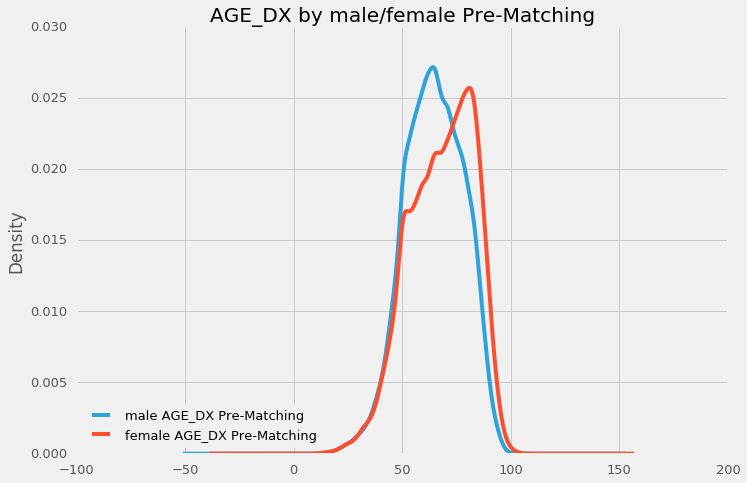

In [57]:
apre = dftreeleague['AGE_DX'][dftreeleague['League'] == 1]
bpre = dftreeleague['AGE_DX'][dftreeleague['League'] == 0]
apost = dftreeleague['AGE_DX'][treatmentindices]
bpost = dftreeleague['AGE_DX'][controlindices]


apre.plot(kind='kde',label='male AGE_DX Pre-Matching')
bpre.plot(kind='kde',label='female AGE_DX Pre-Matching')
plt.title('AGE_DX by male/female Pre-Matching')
plt.legend(loc=3);

In [58]:
apost.plot(kind='kde',label='male AGE_DX Post-Matching')
bpost.plot(kind='kde',label='female AGE_DX Post-Matching')
plt.title('AGE_DX by male/female Post-Matching')
plt.legend(loc=3);

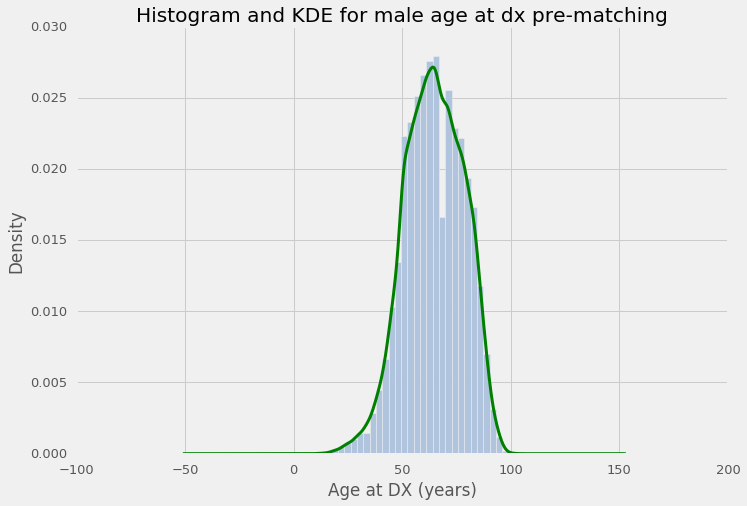

In [68]:
ax = apre.hist(bins=35, color='LightSteelBlue',normed=True)
apre.plot(kind='kde',lw=3, color='Green',ax=ax)
plt.title('Histogram and KDE for male age at dx pre-matching')
plt.xlabel('Age at DX (years)');

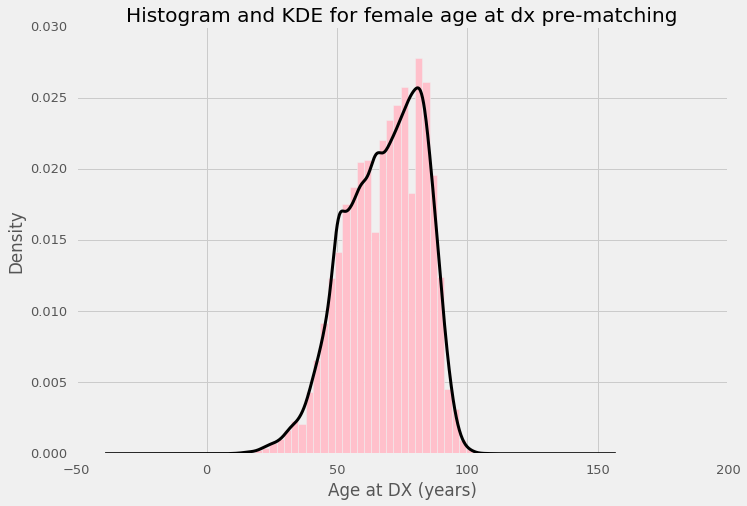

In [67]:
ax = bpre.hist(bins=35, color='Pink',normed=True)
bpre.plot(kind='kde',lw=3, color='Black',ax=ax)
plt.title('Histogram and KDE for female age at dx pre-matching')
plt.xlabel('Age at DX (years)');

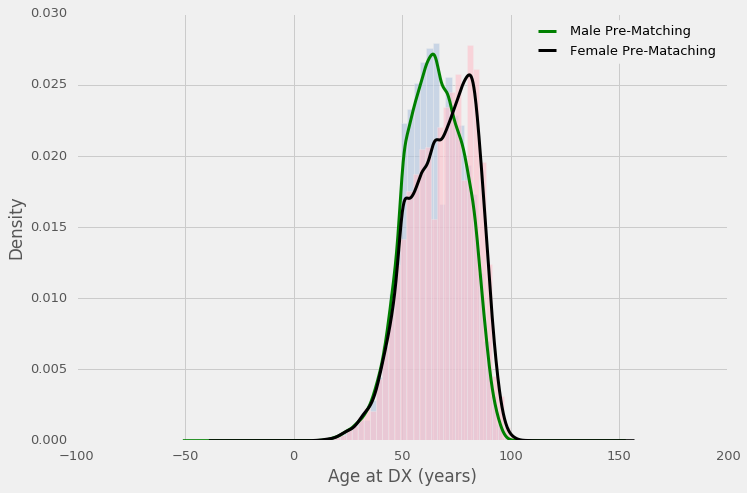

In [69]:
ax = apre.hist(bins=35, color='LightSteelBlue',normed=True,alpha=.6)
apre.plot(kind='kde',lw=3, color='Green',ax=ax,label='Male Pre-Matching')
bpre.hist(bins=35, color='Pink',normed=True,alpha=.6)
bpre.plot(kind='kde',lw=3, color='Black',ax=ax,label='Female Pre-Mataching')
plt.xlabel('Age at DX (years)')
plt.legend();

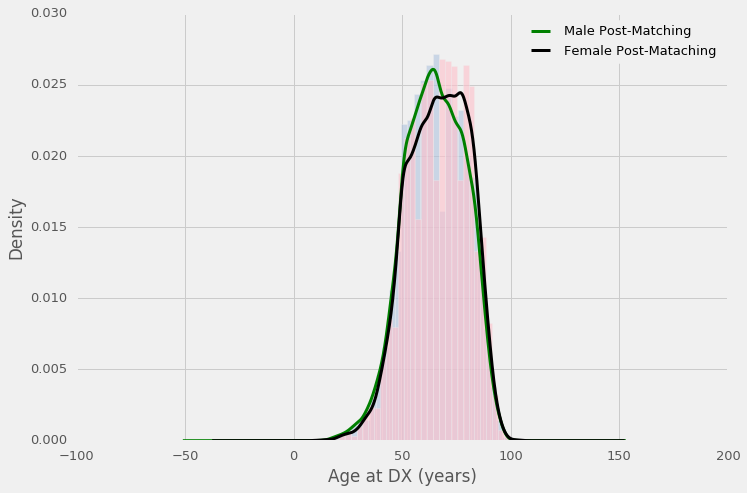

In [70]:
ax = apost.hist(bins=35, color='LightSteelBlue',normed=True,alpha=.6)
apost.plot(kind='kde',lw=3, color='Green',ax=ax,label='Male Post-Matching')
bpost.hist(bins=35, color='Pink',normed=True,alpha=.6)
bpost.plot(kind='kde',lw=3, color='Black',ax=ax,label='Female Post-Mataching')
plt.xlabel('Age at DX (years)')
plt.legend();

In [71]:
def make_pre_post_plots(columnname,df=dftreeleague,splitcolumn='League',
                       treatmentindices=treatmentindices,
                       controlindices=controlindices):
    """Takes a columnname and makes plots of the CDFs for the pre-matching and post-matching as
    well as makes plots of the summaries for the pre and postmatching cases."""
    
    from scipy import stats
    
    ALPOST = df[columnname][treatmentindices].value_counts(normalize=True).sort_index().cumsum()
    NLPOST = df[columnname][controlindices].value_counts(normalize=True).sort_index().cumsum()
    
    dfpost = pd.DataFrame({'MALE_POST_' + columnname: ALPOST,
                           'FEMALE_POST_' + columnname: NLPOST})
    
    dfpost = dfpost.fillna(method='ffill')
    
    dfalpostdescribe = df[columnname][treatmentindices].describe()
    dfnlpostdescribe = df[columnname][controlindices].describe()
    
    dfpostdescribe = pd.DataFrame({'MALE_POST_' + columnname: dfalpostdescribe,
                             'FEMALE_POST_' + columnname: dfnlpostdescribe})
    
    ALPRE = df[columnname][df[splitcolumn] == 1].value_counts(normalize=True).sort_index().cumsum()
    NLPRE = df[columnname][df[splitcolumn] == 0].value_counts(normalize=True).sort_index().cumsum()
    
    
    
    
    dfpre = pd.DataFrame({'MALE_PRE_' + columnname: ALPRE,
                       'FEMALE_PRE_' + columnname: NLPRE})
    
    dfpre = dfpre.fillna(method='ffill')
    
    dfalpredescribe = df[columnname][df[splitcolumn] == 1].describe()
    dfnlpredescribe = df[columnname][df[splitcolumn] == 0].describe()
    
    dfpredescribe = pd.DataFrame({'MALE_PRE_' + columnname: dfalpredescribe,
                             'FEMALE_PRE_' + columnname: dfnlpredescribe})
    
    ALPREvals = df[columnname][df[splitcolumn] == 1].values
    NLPREvals = df[columnname][df[splitcolumn] == 0].values
    ALPOSTvals = df[columnname][treatmentindices].values
    NLPOSTvals = df[columnname][controlindices].values
    
    preresults = stats.ks_2samp(ALPREvals, NLPREvals)
    postresults = stats.ks_2samp(ALPOSTvals, NLPOSTvals)
    
    f, axarr = plt.subplots(2,2,figsize=(10,8))
    
    ax = axarr[0, 0]
    titlepre = columnname +  ' cdf pre-matching: \n' + 'ks statistic: ' + \
    str(preresults.statistic) +'\n pvalue: ' + str(preresults.pvalue)
    dfpre.plot(title=titlepre ,ax=ax,drawstyle='steps')
    
    
    titlepost = columnname +  ' cdf post-matching: \n' + 'ks statistic: ' + \
    str(postresults.statistic) +'\n pvalue: ' + str(postresults.pvalue)
    ax = axarr[0,1]
    dfpost.plot(title=titlepost,ax=ax,drawstyle='steps')
    
    
    ax = axarr[1,0]
    ax = dfpredescribe.iloc[1:].plot(kind='bar', title='pre-matching',
                      ax=ax)
    ax.legend(loc='lower right')
    
    ax = axarr[1,1]
    ax = dfpostdescribe.iloc[1:].plot(kind='bar', title='post-matching',
                       ax=ax)
    ax.legend(loc='lower right')

We can see the results of matching by comparing how much closer the distributions of different features are between the treatment group (the MALE patients that are matched) and the control group (the corresponding matched FEMALE patients) (post matching) than are the corresponding distributions for all MALE patients as compared to all FEMALE patients (pre matching). As a metric to compare distributions, use the Kolmogorov-Smirnov statistic on 2 samples. If this K-S statistic is small or the p-value is high, then we cannot reject the hypothesis that the distributions of the two samples are the same (which is what we want in the post matching case).

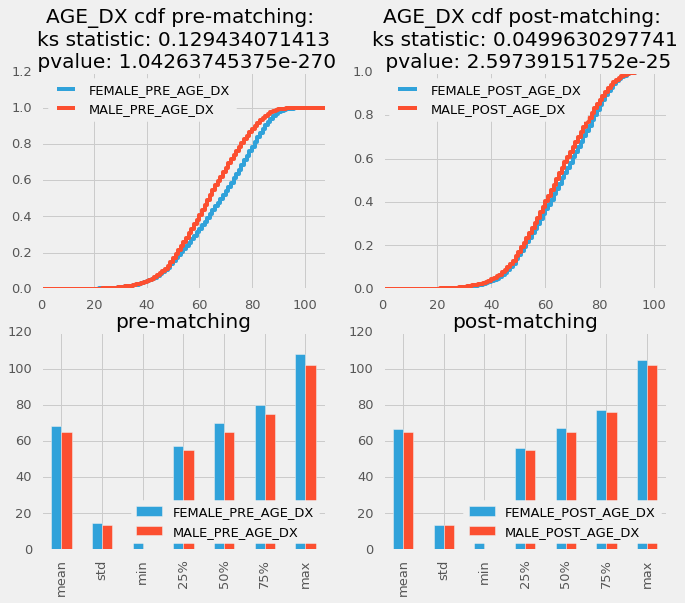

In [72]:
make_pre_post_plots('AGE_DX')

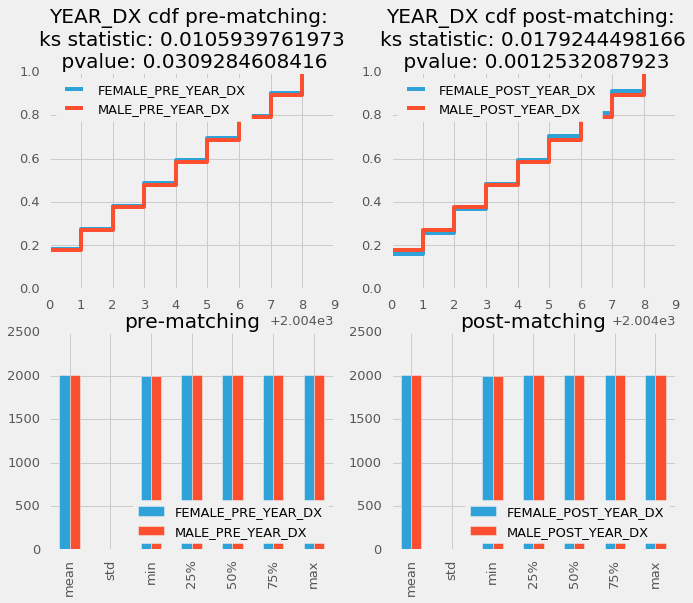

In [73]:
make_pre_post_plots('YEAR_DX')

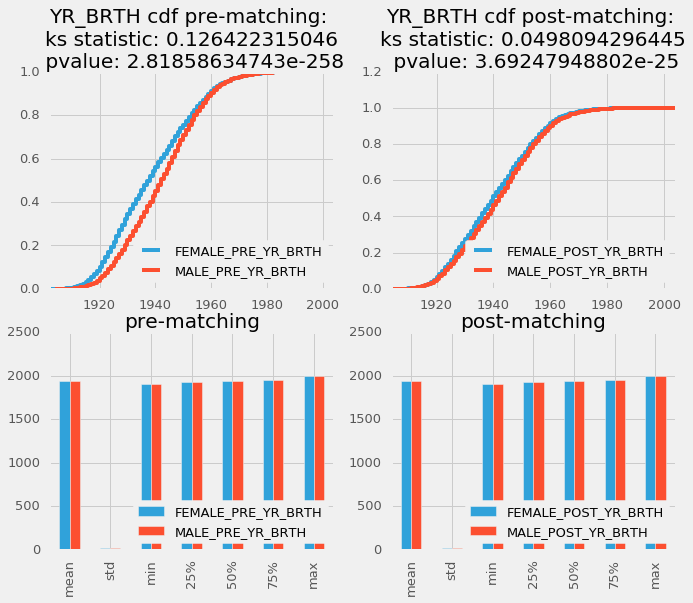

In [74]:
make_pre_post_plots('YR_BRTH')

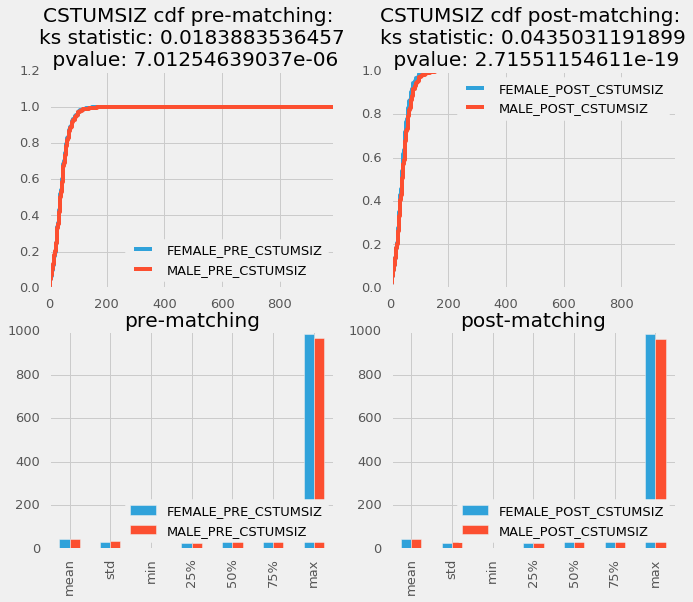

In [75]:
make_pre_post_plots('CSTUMSIZ')


In [76]:
dfsmall['League'] = dftreeleague['League']

In [77]:
def make_pre_post_plots_cat(columnname,df=dftreeleague,splitcolumn='League',
                       treatmentindices=treatmentindices,
                       controlindices=controlindices):
    """Takes a columnname and makes plots of the CDFs for the pre-matching and post-matching as
    well as makes plots of the summaries for the pre and postmatching cases."""
    
    from scipy import stats
    
    ALPOST = df[columnname][treatmentindices].value_counts(normalize=True).sort_index().cumsum()
    NLPOST = df[columnname][controlindices].value_counts(normalize=True).sort_index().cumsum()
    
    dfpost = pd.DataFrame({'MALE_POST_' + columnname: ALPOST,
                           'FEMALE_POST_' + columnname: NLPOST})
    
    dfpost = dfpost.fillna(method='ffill')
    
    dfalpostdescribe = df[columnname][treatmentindices].value_counts(normalize=True).sort_index()
    dfnlpostdescribe = df[columnname][controlindices].value_counts(normalize=True).sort_index()
    
    dfpostdescribe = pd.DataFrame({'MALE_POST_' + columnname: dfalpostdescribe,
                             'FEMALE_POST_' + columnname: dfnlpostdescribe})
    
    ALPRE = df[columnname][df[splitcolumn] == 1].value_counts(normalize=True).sort_index().cumsum()
    NLPRE = df[columnname][df[splitcolumn] == 0].value_counts(normalize=True).sort_index().cumsum()
    
    
    
    
    dfpre = pd.DataFrame({'MALE_PRE_' + columnname: ALPRE,
                       'FEMALE_PRE_' + columnname: NLPRE})
    
    dfpre = dfpre.fillna(method='ffill')
    
    dfalpredescribe = df[columnname][df[splitcolumn] == 1].value_counts(normalize=True)
    dfnlpredescribe = df[columnname][df[splitcolumn] == 0].value_counts(normalize=True)
    
    dfpredescribe = pd.DataFrame({'MALE_PRE_' + columnname: dfalpredescribe,
                             'FEMALE_PRE_' + columnname: dfnlpredescribe})
    
    ALPREvals = df[columnname][df[splitcolumn] == 1].values
    NLPREvals = df[columnname][df[splitcolumn] == 0].values
    ALPOSTvals = df[columnname][treatmentindices].values
    NLPOSTvals = df[columnname][controlindices].values
    
    preresults = stats.ks_2samp(ALPREvals, NLPREvals)
    postresults = stats.ks_2samp(ALPOSTvals, NLPOSTvals)
    
    f, axarr = plt.subplots(2,2,figsize=(10,8))
    
    ax = axarr[0, 0]
    titlepre = columnname +  ' cdf pre-matching: \n' + 'ks statistic: ' + \
    str(preresults.statistic) +'\n pvalue: ' + str(preresults.pvalue)
    dfpre.plot(title=titlepre ,ax=ax,drawstyle='steps')
    ax.tick_params(labelbottom='off')
    
    titlepost = columnname +  ' cdf post-matching: \n' + 'ks statistic: ' + \
    str(postresults.statistic) +'\n pvalue: ' + str(postresults.pvalue)
    ax = axarr[0,1]
    dfpost.plot(title=titlepost,ax=ax,drawstyle='steps')
    ax.tick_params(labelbottom='off')
    
    
    ax = axarr[1,0]
    ax = dfpredescribe.plot(kind='bar', title='pre-matching',
                      ax=ax)
    ax.legend(loc='upper right')
    
    
    ax = axarr[1,1]
    ax = dfpostdescribe.plot(kind='bar', title='post-matching',
                       ax=ax)
    ax.legend(loc='upper right')
    

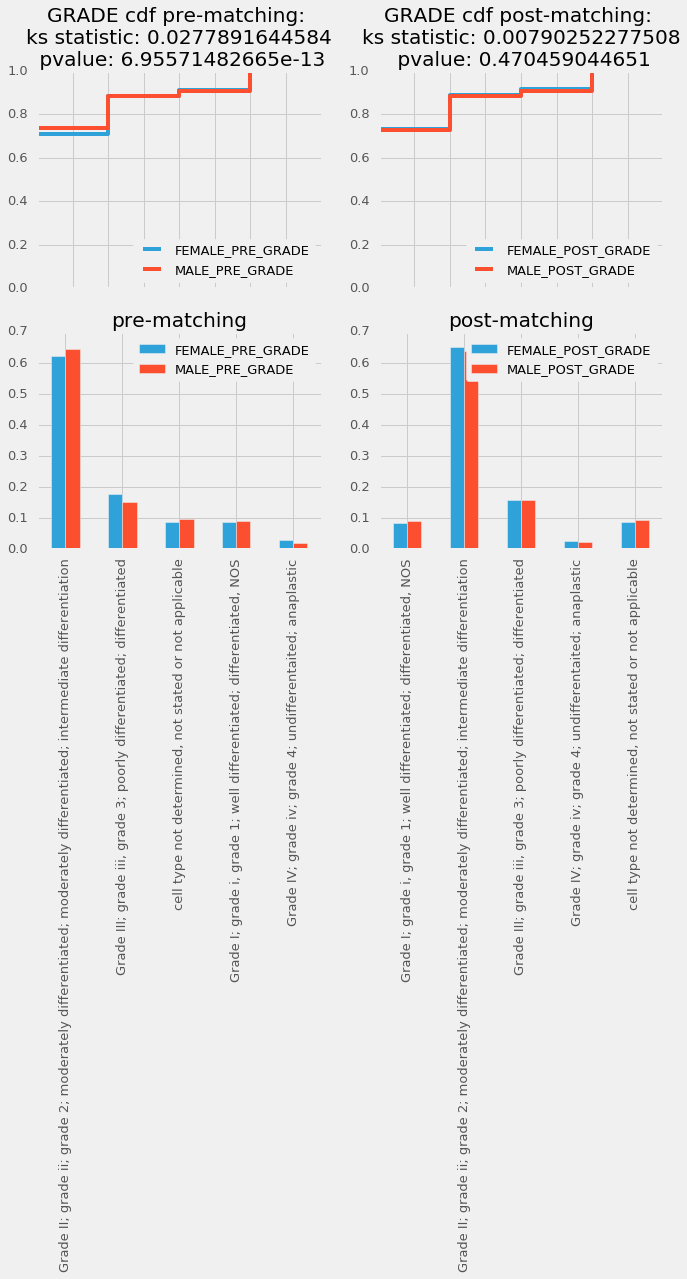

In [78]:
make_pre_post_plots_cat('GRADE',df=dfsmall)

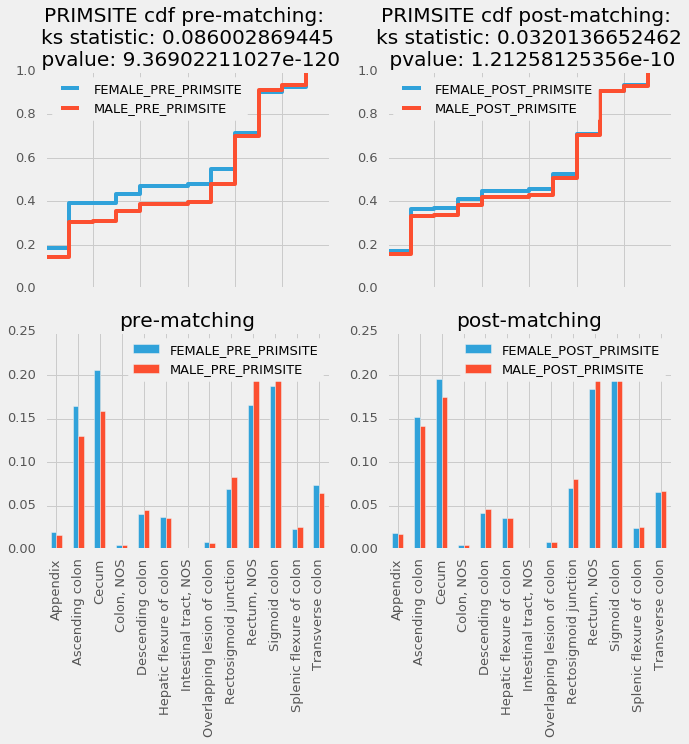

In [79]:
make_pre_post_plots_cat('PRIMSITE',df=dfsmall)

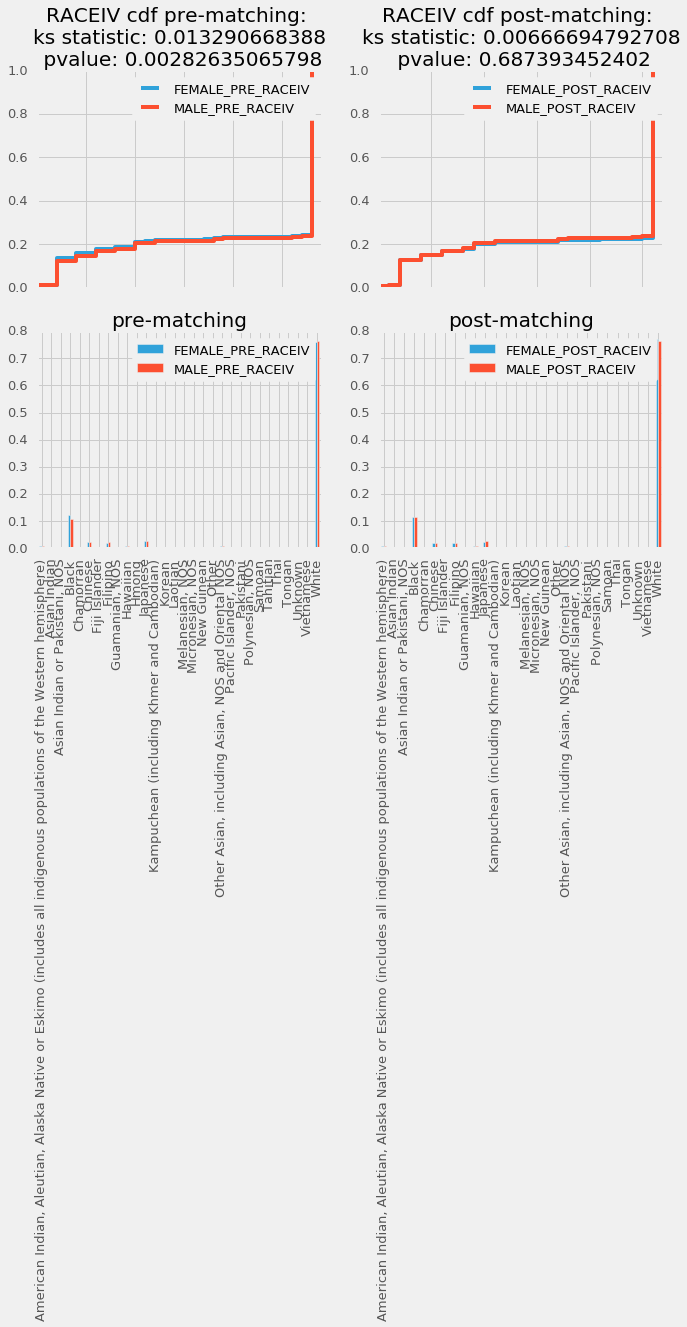

In [80]:
make_pre_post_plots_cat('RACEIV',df=dfsmall)


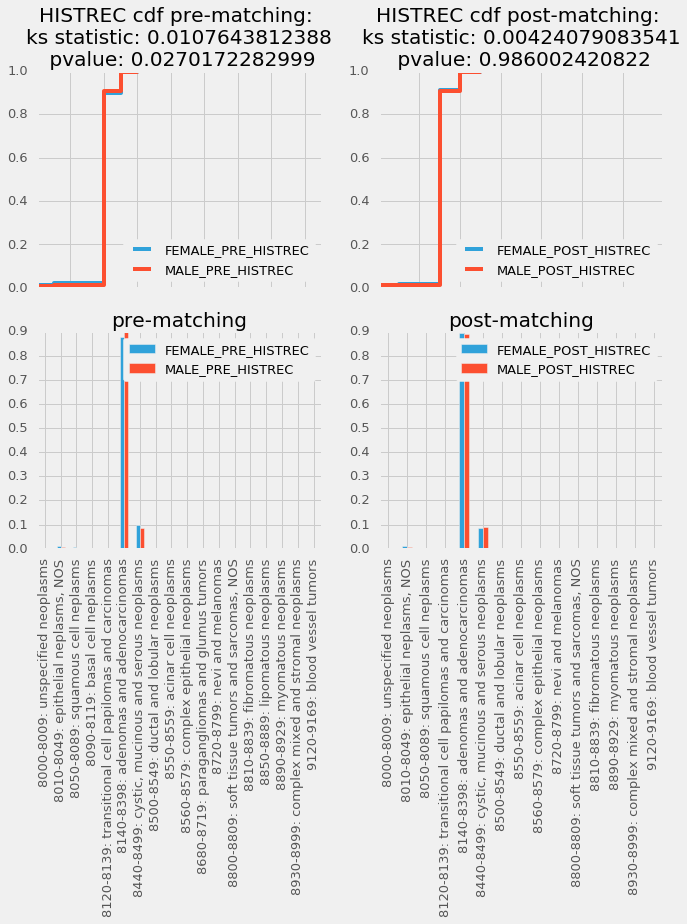

In [81]:
make_pre_post_plots_cat('HISTREC',df=dfsmall)


In [82]:
def make_stats_dataframe(df=dfsmall,splitcolumn='League',
                        treatmentindices=treatmentindices,
                        controlindices=controlindices):
    """Loops through all of the columns in df and retuns a new dataframe with the statistics of the
    pre and post matched cdfs for each column."""
    
    from scipy import stats
    
    total_dict = dict()
    
    for columnname in df.columns:
        try:
    
            ALPREvals = df[columnname][df[splitcolumn] == 1].values
            NLPREvals = df[columnname][df[splitcolumn] == 0].values
            ALPOSTvals = df[columnname][treatmentindices].values
            NLPOSTvals = df[columnname][controlindices].values
    
            preresults = stats.ks_2samp(ALPREvals, NLPREvals)
            postresults = stats.ks_2samp(ALPOSTvals, NLPOSTvals)
    
            statslist = [preresults.statistic, preresults.pvalue, 
                    postresults.statistic, postresults.pvalue]
        
            total_dict[columnname] = statslist
        except:
            pass
     
    dfstats = pd.DataFrame.from_dict(total_dict, orient='index')
    dfstats.columns = ['pre_ks_stat','pre_pvalue','post_ks_stat','post_pvalue']
    
    #dfstats.drop(['neighbor_1','neighbor_2','neighbor_3',
    #             'neighbor_1_League','neighbor_2_League','neighbor_3_League',
     #            'distance_1','distance_2','distance_3'],inplace=True)
    
    return dfstats

In [83]:
dfsmall['YR_BRTH'] = dfsmall['YR_BRTH'].astype('int')
dfsmall['AGE_DX'] = dfsmall['AGE_DX'].astype('int')
dfsmall['CSTUMSIZ'] = dfsmall['CSTUMSIZ'].astype('float')
dfsmall['elevation'] = dfsmall['elevation'].astype('float')
dfsmall['lat'] = dfsmall['lat'].astype('float')
dfsmall['lng'] = dfsmall['lng'].astype('float')
dfsmall['srv_time_mon'] = dfsmall['srv_time_mon'].astype('float')

In [84]:

dfstats = make_stats_dataframe(df=dfsmall)
dfstats

pre_ks_stat    pre_pvalue  post_ks_stat   post_pvalue
CSMETSDX              0.009330  7.881627e-02      0.015621  7.387066e-03
SURGSITF              0.016525  7.859360e-05      0.015092  1.072283e-02
N_VALUE               0.000000  1.000000e+00      0.000000  1.000000e+00
EOD10_SZ              0.000000  1.000000e+00      0.000000  1.000000e+00
M_VALUE               0.000000  1.000000e+00      0.000000  1.000000e+00
NHIADE                0.007965  1.893172e-01      0.005526  8.746435e-01
srv_time_mon_flag     0.000000  1.000000e+00      0.000000  1.000000e+00
REG                   0.009756  5.827564e-02      0.012989  4.160712e-02
intprim               0.002352  9.999521e-01      0.001595  1.000000e+00
LATERAL               0.000214  1.000000e+00      0.000103  1.000000e+00
STATE                 0.017519  2.236924e-05      0.019265  3.991885e-04
CS13SITE              0.000000  1.000000e+00      0.000000  1.000000e+00
EOD4                  0.000000  1.000000e+00      0.000000  1.000000e+00
her2                  0.000000  1.000000e+00      0.000000  1.000000e+00
CS5SITE               0.000000  1.000000e+00      0.000000  1.000000e+00
EOD10_EX              0.000000  1.000000e+00      0.000000  1.000000e+00
TUMOR_3V              0.000000  1.000000e+00      0.000000  1.000000e+00
CSMTEVAL              0.004520  8.424861e-01      0.010865  1.330674e-01
BEHO3V                0.002352  9.999521e-01      0.001595  1.000000e+00
SUMM2K                0.003712  9.600288e-01      0.010602  1.514144e-01
CS8SITE               0.010604  3.068481e-02      0.013588  2.886441e-02
CS11SITE              0.000000  1.000000e+00      0.000000  1.000000e+00
CODPUB                0.019392  1.713368e-06      0.039276  8.362946e-16
MAR_STAT              0.204444  0.000000e+00      0.072521  7.403540e-53
VASINV                0.000000  1.000000e+00      0.000000  1.000000e+00
ST_CNTY_ORIG          0.017519  2.236924e-05      0.019265  3.991885e-04
EOD_CODE              0.000000  1.000000e+00      0.000000  1.000000e+00
CS4SITE               0.010212  4.154750e-02      0.013805  2.518816e-02
AJ_3SEER              0.000000  1.000000e+00      0.000000  1.000000e+00
YEAR_DX               0.010594  3.092846e-02      0.017924  1.253209e-03
...                        ...           ...           ...           ...
CSVCURRENT            0.019371  1.766088e-06      0.018672  6.685018e-04
DAJCCFL               0.000000  1.000000e+00      0.000000  1.000000e+00
MDXRECMP              0.006011  5.132403e-01      0.005545  8.720627e-01
RADIATN               0.050619  9.169416e-42      0.022429  1.930529e-05
CSEXTEN               0.018046  1.113985e-05      0.010440  1.637321e-01
lat                   0.017767  1.615977e-05      0.025899  4.113802e-07
HST_STGA              0.010720  2.798682e-02      0.017329  2.029368e-03
HISTRECB              0.000000  1.000000e+00      0.000000  1.000000e+00
GRADE                 0.027789  6.955715e-13      0.007903  4.704590e-01
SSS77VZ               0.000000  1.000000e+00      0.000000  1.000000e+00
CSRGEVAL              0.000000  1.000000e+00      0.000000  1.000000e+00
CS7SITE               0.000000  1.000000e+00      0.000000  1.000000e+00
ADJTM_6VALUE          0.000000  1.000000e+00      0.000000  1.000000e+00
SEQ_NUM               0.010176  4.271409e-02      0.011439  9.916935e-02
prstatus              0.000000  1.000000e+00      0.000000  1.000000e+00
ODTHCLASS             0.010010  4.835222e-02      0.018957  5.227495e-04
cs0204schema          0.070084  1.145946e-79      0.029381  4.955661e-09
DSS1977S              0.007981  1.874712e-01      0.012935  4.294870e-02
STAT_REC              0.001127  1.000000e+00      0.038865  1.748689e-15
CSTUMSIZ              0.018388  7.012546e-06      0.043503  2.715512e-19
EOD10_ND              0.000000  1.000000e+00      0.000000  1.000000e+00
CS25SITE              0.000000  1.000000e+00      0.000000  1.000000e+00
TYPE_FU               0.000000  1.000000e+00      0.000000  1.000000e+00
HIST

## <font color='purple'>Who is more likely to have insurance: Male or Female colon Cancer Patients</font>

matched males $\rightarrow$ treatmentindices
matched females $\rightarrow$ controlindices

We will answer this question using Bayesian A/B testing

We can use Bayesian A/B testing for all the questions where either a desired event (they have insurance) occured or not.

In [85]:
# the matched male patients insurance status; ignores the missing values
dfsmall['INSREC_PUB'][treatmentindices].value_counts()
# so the probability a male colon cancer patient is insured is

Insured                     12714
Insured/No specifics         3048
Any Medicaid                 1626
Insurance status unknown      583
Uninsured                     533
Name: INSREC_PUB, dtype: int64

In [86]:
MALEinsured = dfsmall['INSREC_PUB'][treatmentindices].value_counts()['Insured']
MALEtotal = dfsmall['INSREC_PUB'][treatmentindices].value_counts().sum()
probmale = MALEinsured/MALEtotal
probmale

0.687094682230869

In [87]:
FEMALEinsured = dfsmall['INSREC_PUB'][controlindices].value_counts()['Insured']
FEMALEtotal = dfsmall['INSREC_PUB'][controlindices].value_counts().sum()
probfemale = FEMALEinsured/FEMALEtotal
probfemale

0.70435062842410567

<font color='purple'>Can use Baye's A/B testing to see if we have enough to data to see if the probaility difference of having insurance for males and females with colon cancer is significant or not</font>

In [88]:
MALE_TOTAL = MALEtotal
FEMALE_TOTAL = FEMALEtotal

MALE_INSURED = MALEinsured
FEMALE_INSURED = FEMALEinsured

from scipy.stats import beta
alpha_prior = 1
beta_prior = 1

posterior_male = beta(alpha_prior + MALE_INSURED, beta_prior + MALE_TOTAL - MALE_INSURED)

posterior_female = beta(alpha_prior + FEMALE_INSURED, beta_prior + FEMALE_TOTAL - FEMALE_INSURED)


samples = 2000000

samples_posterior_male = posterior_male.rvs(samples)

samples_posterior_female = posterior_female.rvs(samples)

(samples_posterior_female > samples_posterior_male).mean()

0.99972700000000003

In [89]:
(samples_posterior_female > samples_posterior_male).mean()

0.99972700000000003

<font color='purple'>So we can say that we are 99&#37; certain that female colon cancer patients (as a group) are more likely than
male colon cancer patients (as a group) to have health insurance.

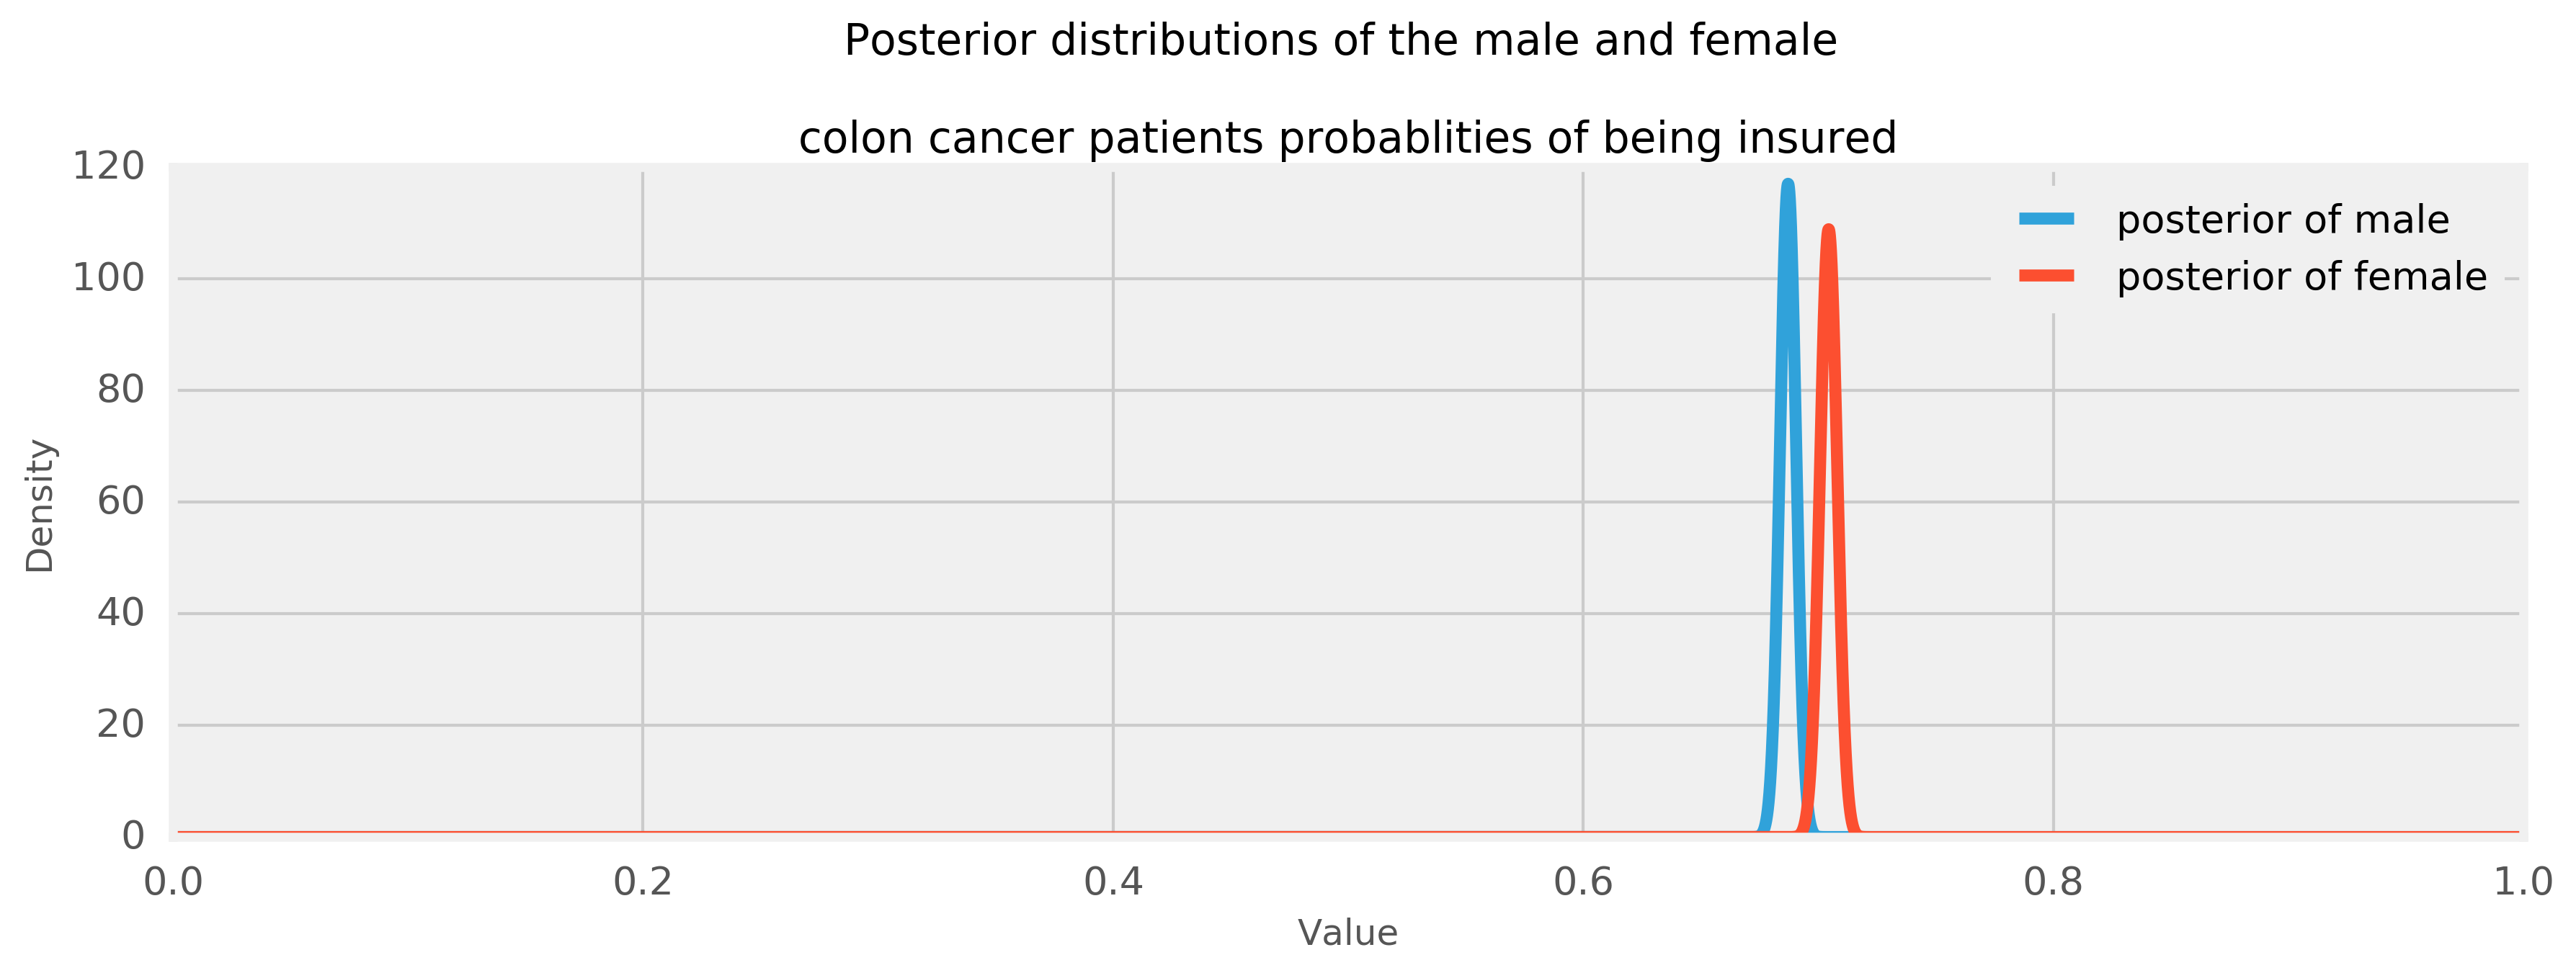

In [90]:
%matplotlib inline
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
figsize(12.5, 4)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300
x = np.linspace(0,1, 50000)
plt.plot(x, posterior_male.pdf(x), label='posterior of male')
plt.plot(x, posterior_female.pdf(x), label='posterior of female')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title("""Posterior distributions of the male and female \n 
colon cancer patients probablities of being insured""")
plt.legend();
#plt.xlim(0.02,0.2)

So even though the difference in insurance coverage between male and female patients is quite small, there is enough data to show that the observed difference is not due to chance, but is a real effect! The more data, the more narrow is the posterior distribution.

## <font color='purple'>Another question we can ask:</font>

Are male colon cancer patients more likely than female colon patients to have secondary malignancies? I would have thought it doesn't matter, but since females are more likely to have insurance, it may have a trickle down effect.

In [91]:
dfcolon0['REC_NO'].value_counts()

1    437641
2     64983
3      9600
4      1378
5       260
6        37
7         8
8         5
9         3
Name: REC_NO, dtype: int64

I want to find the maximum record number for each of the patients represented by treatmentindicies and controlindices

In [92]:
dfcolon0['REC_NO'][dfcolon0['PUBCSNUM'].isin(treatmentindices)].value_counts()

1    25401
2      949
3       87
4        7
Name: REC_NO, dtype: int64

In [93]:
dfcolon0['SEQ_NUM'][dfcolon0['PUBCSNUM'].isin(treatmentindices)].value_counts()

0     22053
1      2900
2      1335
3       139
4        13
5         2
6         1
99        1
Name: SEQ_NUM, dtype: int64

In [94]:
len(treatmentindices)

25401

In [95]:
dfcolon0['REC_NO'][dfcolon0['PUBCSNUM'].isin(treatmentindices)].max()

4

In [96]:
dfcolon0['REC_NO'][dfcolon0['PUBCSNUM'].isin(controlindices)].value_counts()

1    20853
2      653
3       59
4        6
5        3
6        1
Name: REC_NO, dtype: int64

In [97]:
malesrecno = dfcolon0['REC_NO'][dfcolon0['PUBCSNUM'].isin(treatmentindices)]

In [98]:
malesrecno.shape

(26444,)

In [99]:
femalesrecno = dfcolon0['REC_NO'][dfcolon0['PUBCSNUM'].isin(controlindices)]

In [100]:
femalesrecno.shape

(21575,)

I need to find the maximum value of ```malesrecno``` and ```femalesrecno``` for each index (patient)

In [101]:
malesrecno.head()

70      1
544     1
661     1
893     1
1060    1
Name: REC_NO, dtype: int64

In [102]:
dfcolon0['REC_NO_MAX'] = dfcolon0.groupby(['PUBCSNUM'])['REC_NO'].transform(max)

In [103]:
dfcolon0[['REC_NO','REC_NO_MAX']][dfcolon0['PUBCSNUM'].isin(treatmentindices)].describe()

REC_NO    REC_NO_MAX
count  26444.000000  26444.000000
mean       1.043261      1.086598
std        0.222620      0.319049
min        1.000000      1.000000
25%        1.000000      1.000000
50%        1.000000      1.000000
75%        1.000000      1.000000
max        4.000000      4.000000

In [104]:
dfcolon0[['PUBCSNUM','REC_NO','REC_NO_MAX']][dfcolon0['PUBCSNUM'].isin(treatmentindices)].describe()

PUBCSNUM        REC_NO    REC_NO_MAX
count  2.644400e+04  26444.000000  26444.000000
mean   2.405903e+07      1.043261      1.086598
std    1.210642e+07      0.222620      0.319049
min    1.131000e+03      1.000000      1.000000
25%    1.291987e+07      1.000000      1.000000
50%    2.214477e+07      1.000000      1.000000
75%    3.581628e+07      1.000000      1.000000
max    4.190267e+07      4.000000      4.000000

In [105]:
dftreatmentrec = dfcolon0[['PUBCSNUM','REC_NO','REC_NO_MAX']][dfcolon0['PUBCSNUM'].isin(treatmentindices)].copy()

In [106]:
dftreatmentrec.shape

(26444, 3)

In [107]:
len(treatmentindices)

25401

In [108]:
dftreatmentrecunique = dftreatmentrec[['PUBCSNUM','REC_NO_MAX']].drop_duplicates()
dftreatmentrecunique.shape

(25401, 2)

In [109]:
dfcontrolrec = dfcolon0[['PUBCSNUM','REC_NO','REC_NO_MAX']][dfcolon0['PUBCSNUM'].isin(controlindices)].copy()
print(dfcontrolrec.shape)
dfcontrolrecunique = dfcontrolrec[['PUBCSNUM','REC_NO_MAX']].drop_duplicates()
print(dfcontrolrecunique.shape)

(21575, 3)
(20853, 2)


In [110]:
males_maxrecs_vals = dftreatmentrecunique['REC_NO_MAX'].values
females_maxrecs_vals = dfcontrolrecunique['REC_NO_MAX'].values

In [111]:
def get_value(vals):
    import random
    pval = random.uniform(0,100)
    #print(pval)
    return np.percentile(vals,pval)


def get_group(vals, numberofsubjects):
    """Returns a pandas series."""
    import random
    a = list()
    for i in range(numberofsubjects):
        try:
            b = get_value(vals)
            a.append(b)
        except:
            pass
    c = pd.Series(a)
    return c

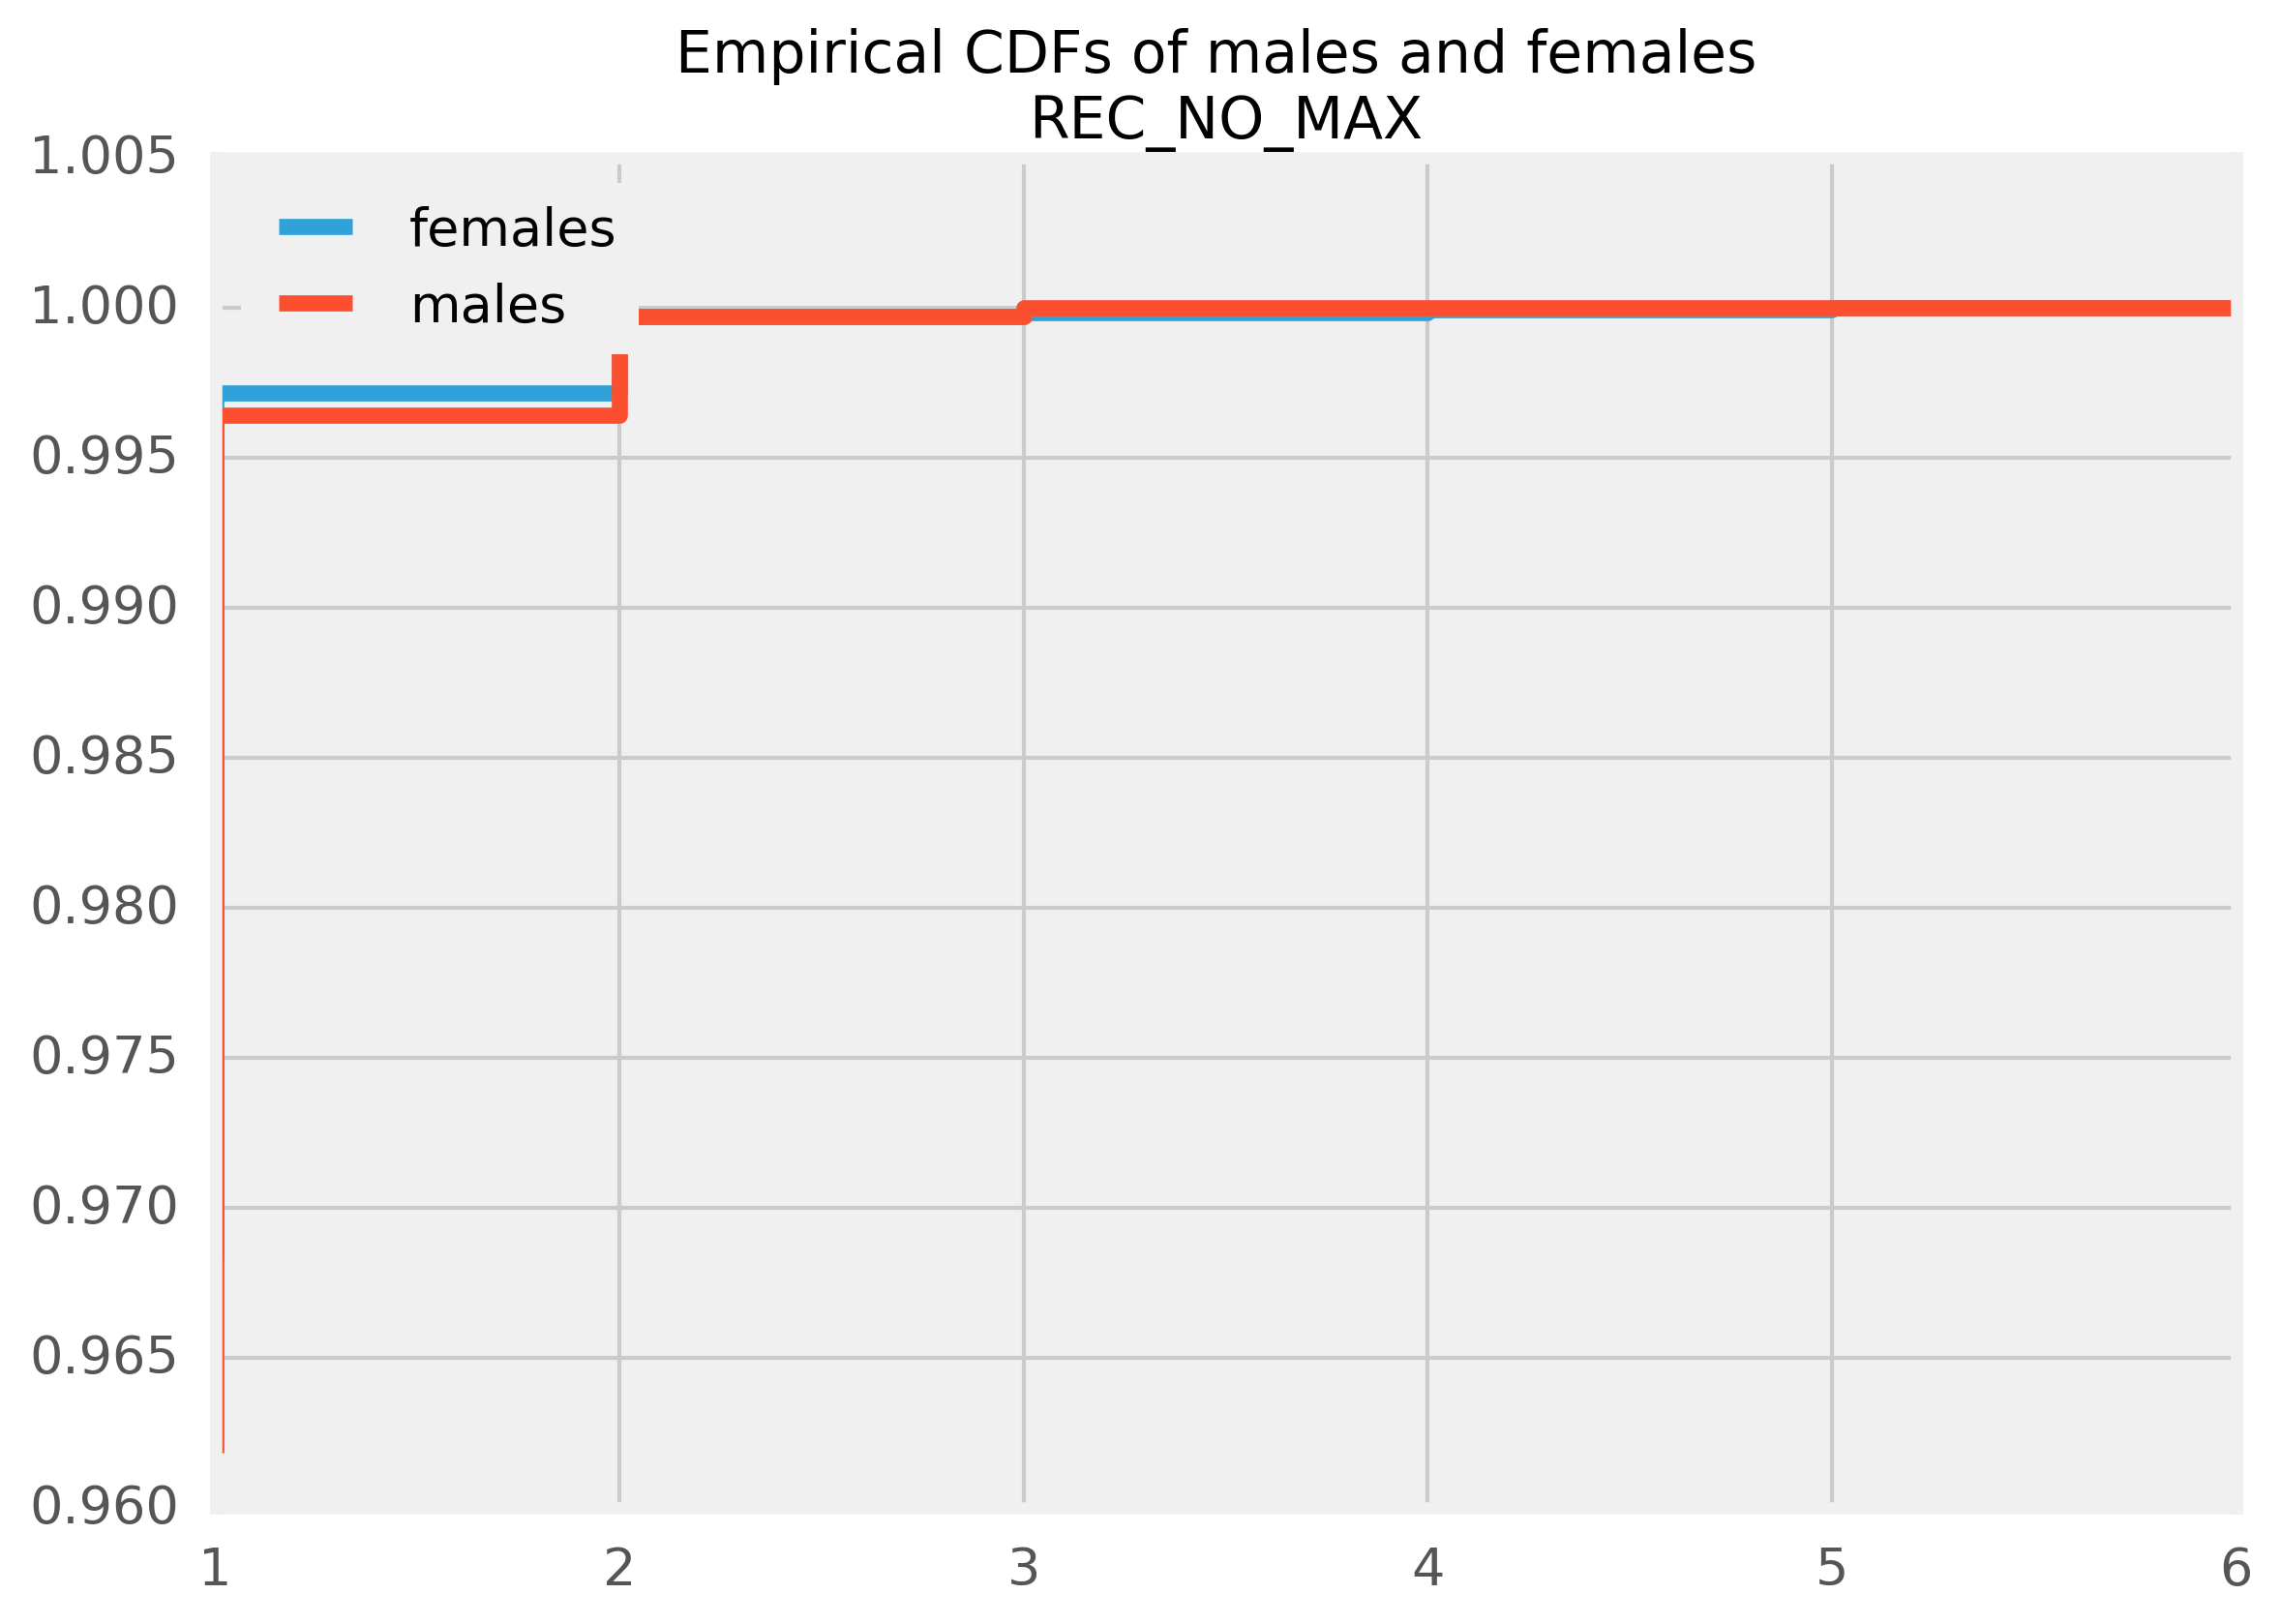

In [112]:
males_data = dftreatmentrecunique['REC_NO_MAX'].value_counts(normalize=True).sort_index().cumsum()
females_data = dfcontrolrecunique['REC_NO_MAX'].value_counts(normalize=True).sort_index().cumsum()

dfdata = pd.DataFrame({'males': males_data,
                     'females': females_data})
dfdata = dfdata.fillna(method='ffill')
dfdata.plot(figsize=(8,6),drawstyle='steps', title = "Empirical CDFs of males and females \n" + 
           "REC_NO_MAX");

## <font color='purple'>So just looking at the Data it does show that males are more likely to have multiple records than females</font>

Now we need to quantiy this observation:

In [113]:
males_maxrecs_vals = dftreatmentrecunique['REC_NO_MAX'].values
females_maxrecs_vals = dfcontrolrecunique['REC_NO_MAX'].values

malessamp = get_group(males_maxrecs_vals, 15000)
femalessamp = get_group(females_maxrecs_vals, 15000)

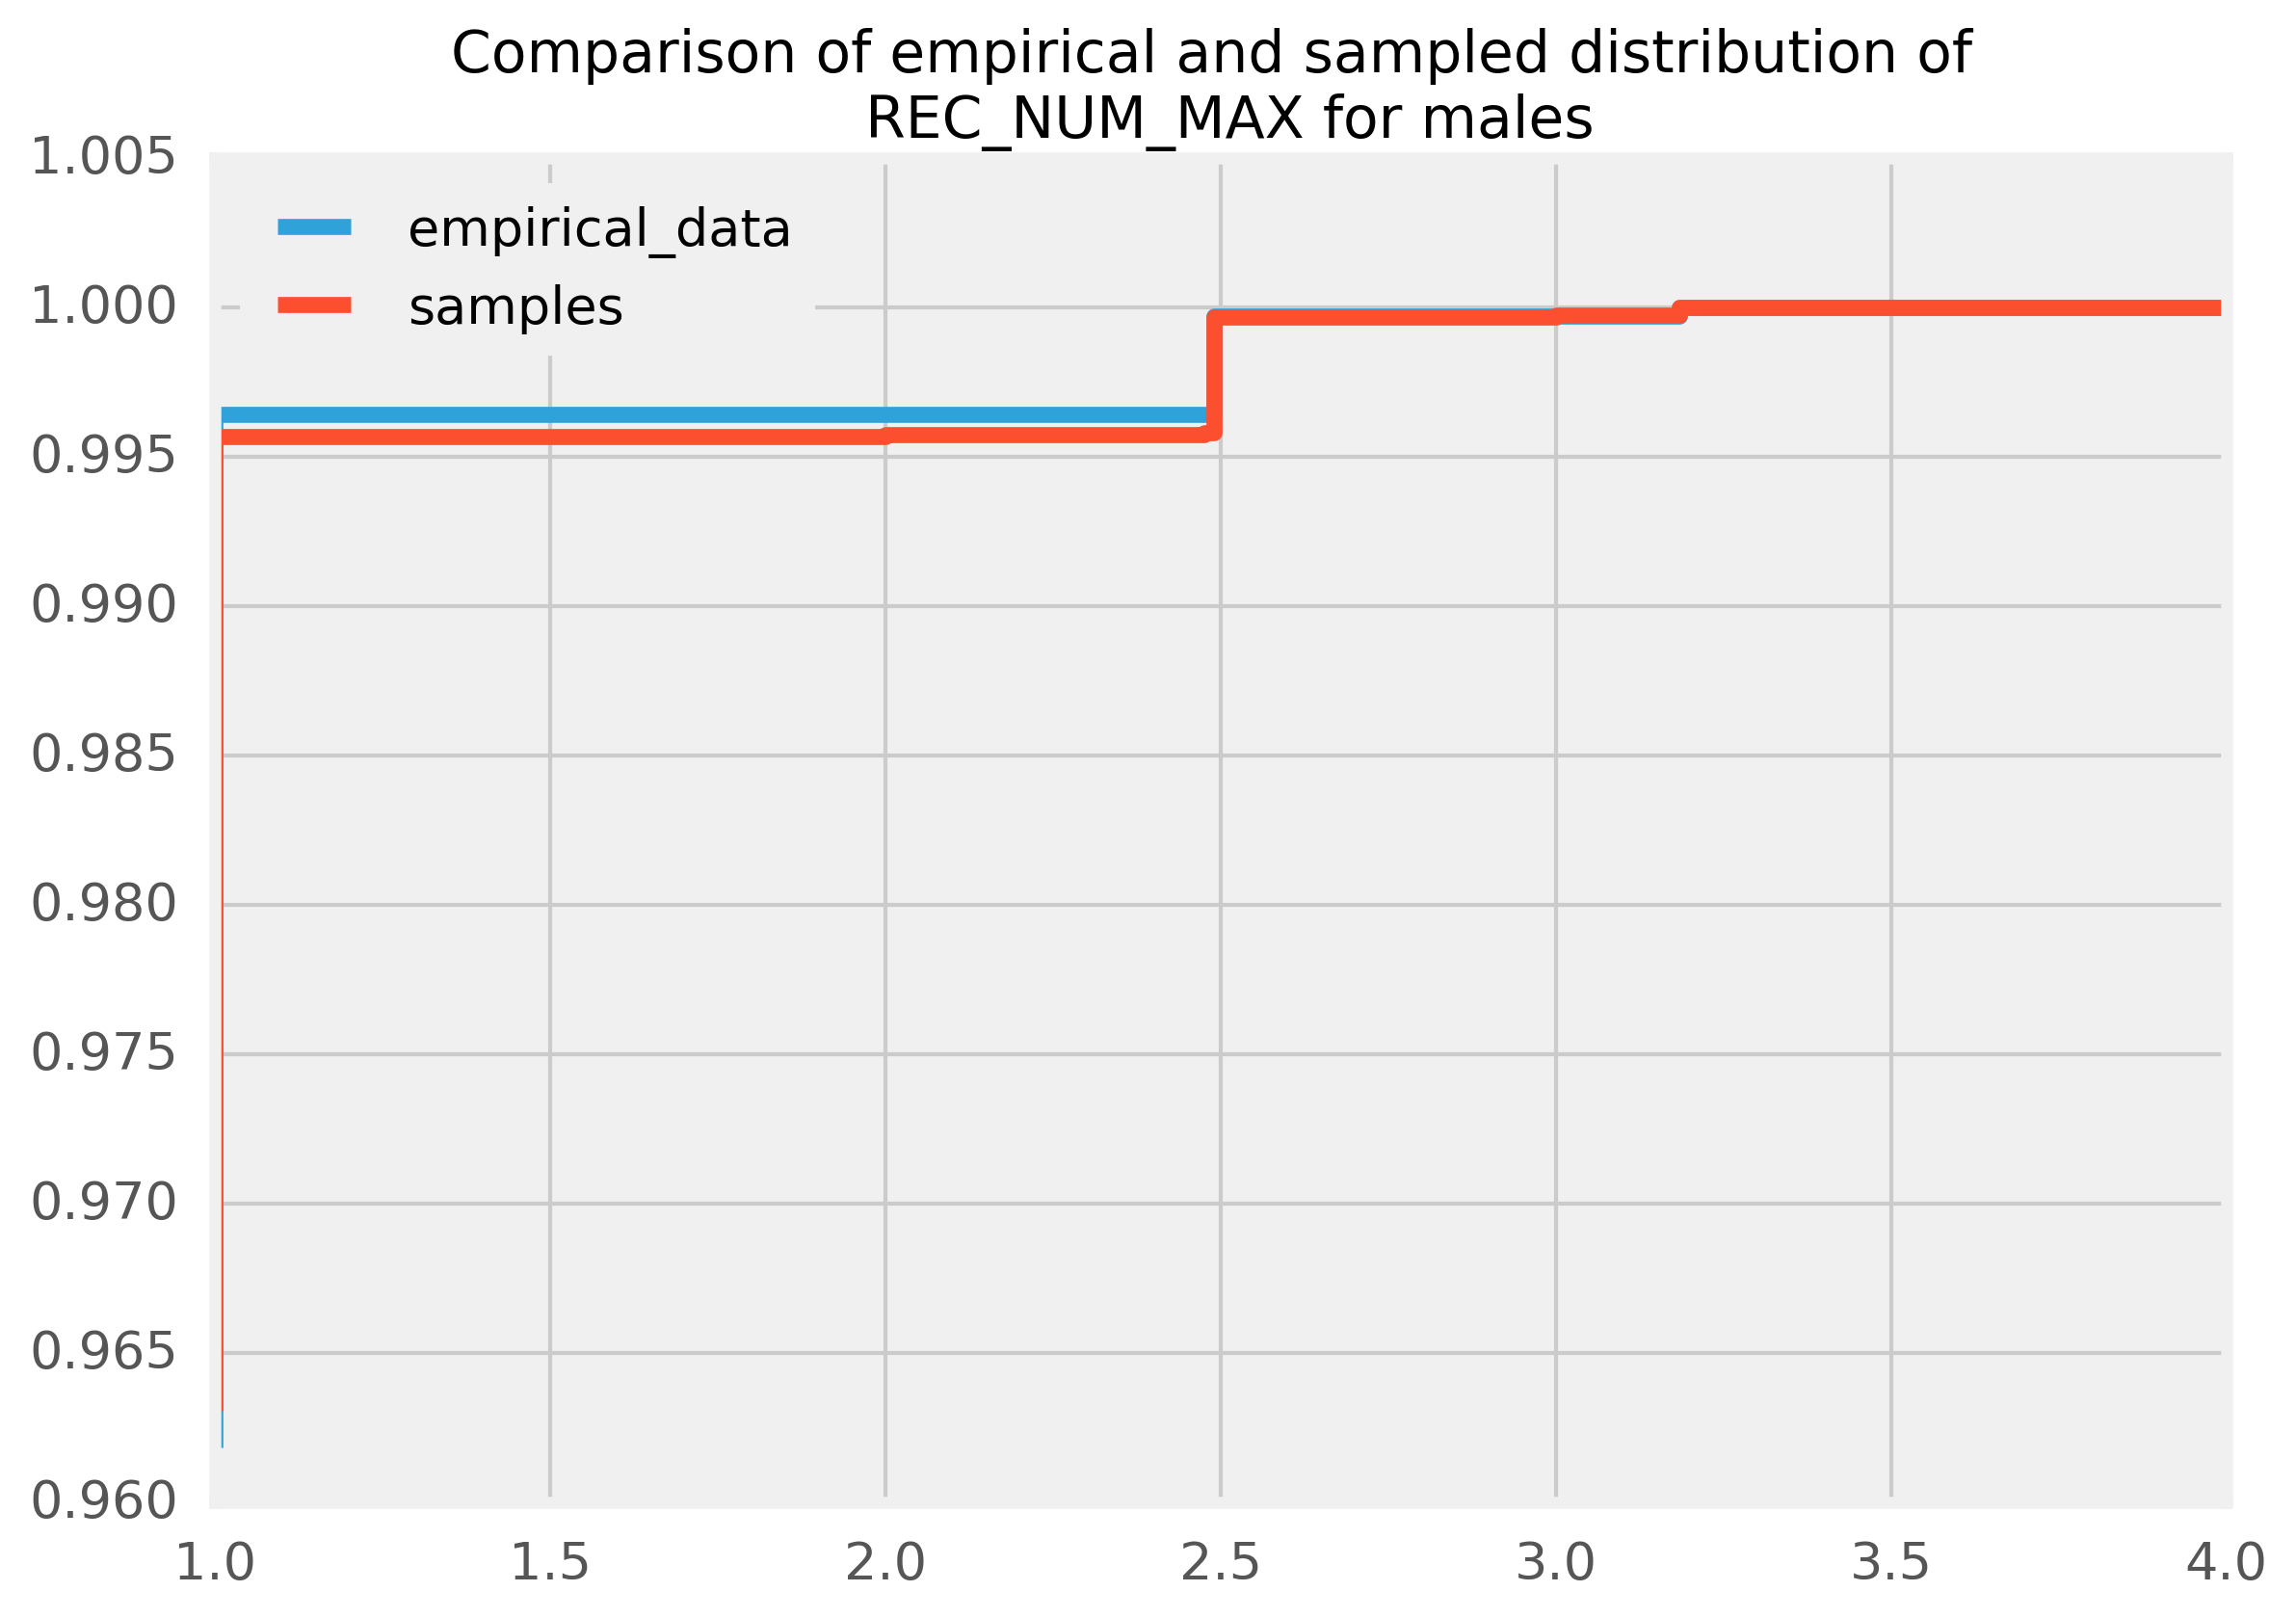

In [114]:
samples = malessamp.value_counts(normalize=True).sort_index().cumsum()
real = dftreatmentrecunique['REC_NO_MAX'].value_counts(normalize=True).sort_index().cumsum()
dfmales = pd.DataFrame({'samples': samples,
                        'empirical_data': real })
dfmales = dfmales.fillna(method='ffill')
dfmales.plot(figsize=(8,6),drawstyle='steps',title="Comparison of empirical " + \
              "and sampled distribution of \n REC_NUM_MAX for males");

In [115]:
(malessamp > femalessamp).values.mean()

0.035866666666666665

In [116]:
(femalessamp > malessamp).values.mean()

0.029666666666666668

In [117]:
(femalessamp == malessamp).values.mean()

0.93446666666666667

### <font color='purple'>They are mostly all single record (single primary tumor) patients</font>
But males have a greater chance of having more tumors than females.

Now lets ask a silly question just to illustate the method with a more interesting, continouous ordered variable just to illustrate the method.

Are male colon cancer patients more likely to live at higher elevation than female colon cancer patients?

First plot the empirical CDFs of 'elevation' for both the treatmentincdices group and the controlindices group.

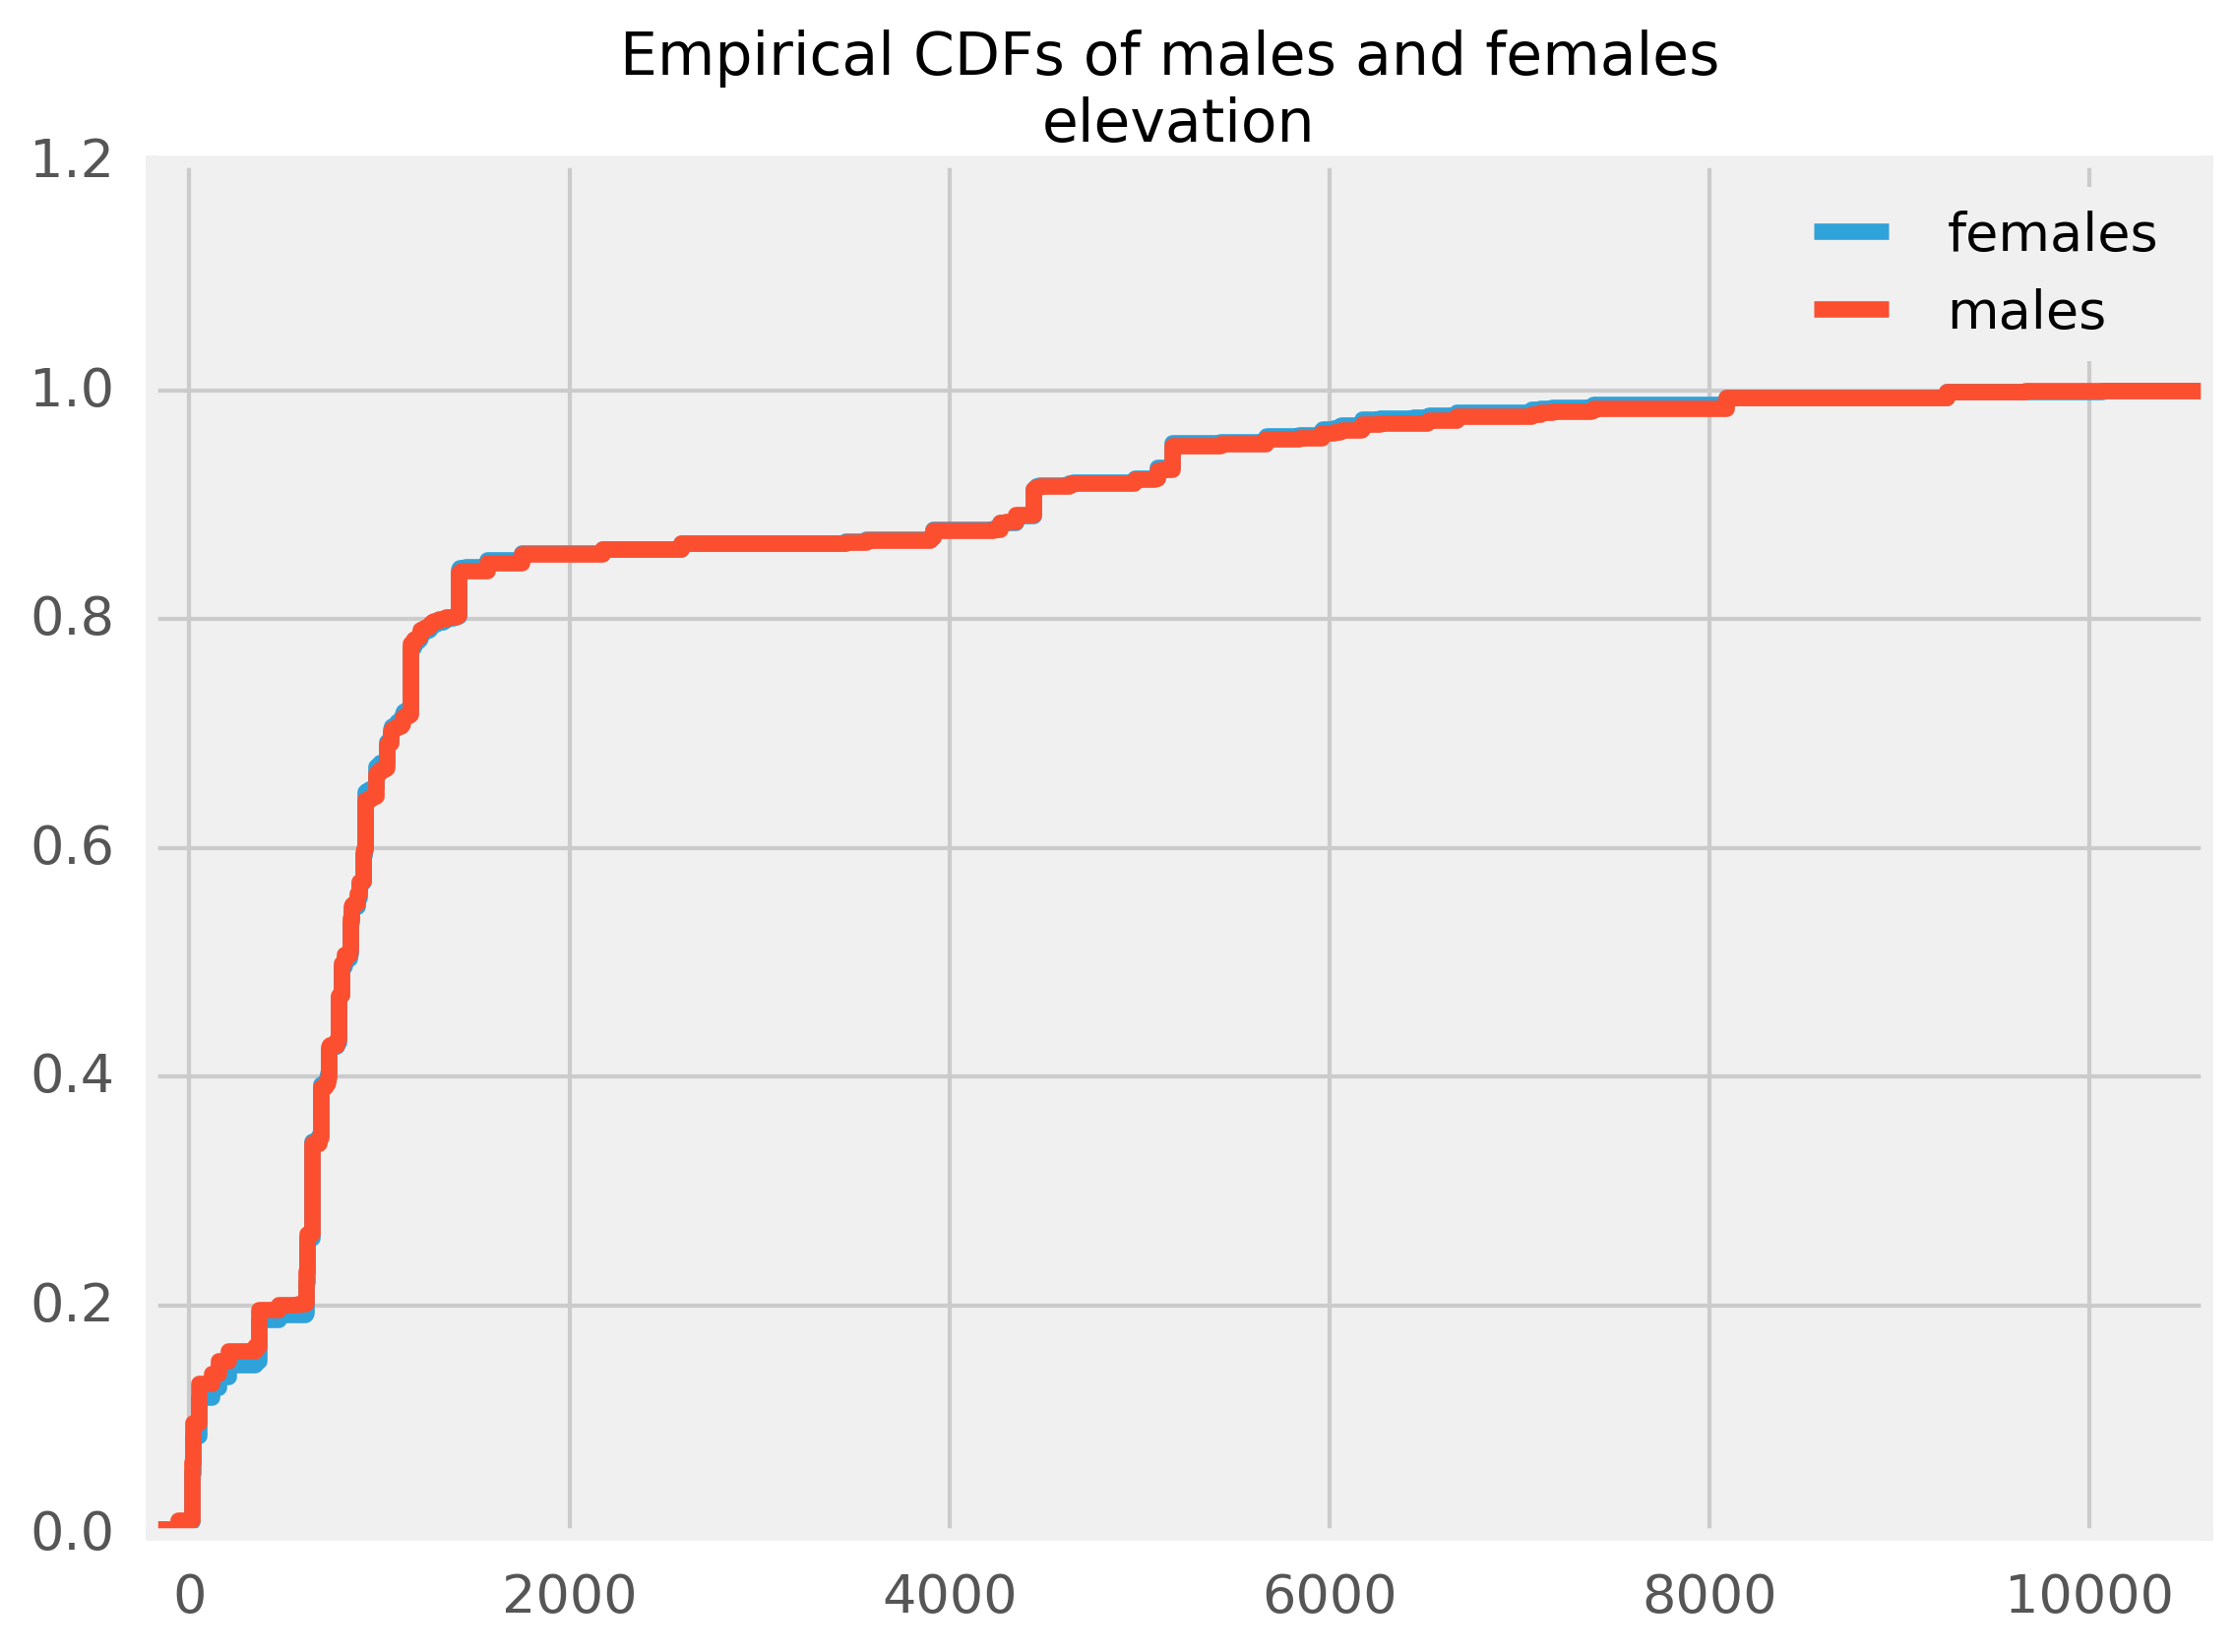

In [118]:
males_data = dfsmall['elevation'][treatmentindices].value_counts(normalize=True).sort_index().cumsum()
females_data = dfsmall['elevation'][controlindices].value_counts(normalize=True).sort_index().cumsum()

dfdata = pd.DataFrame({'males': males_data,
                      'females': females_data})
dfdata = dfdata.fillna(method='ffill')
dfdata.plot(figsize=(8,6),drawstyle='steps', title="Empirical CDFs of males and females \n" + 
           "elevation");

The SEER data is restricted to the patients within the jurisdiction of the SEER registries. This exercise is just to illustate the method. The same method can be applied to the case where instead of `elevation` we consider something like `total_cost_of_care.`

In [119]:
males_elevation_vals = dfsmall['elevation'][treatmentindices].values
females_elevation_vals = dfsmall['elevation'][controlindices].values

malessamp = get_group(males_elevation_vals, 150000)
femalessamp = get_group(females_elevation_vals, 150000)

In [120]:
(malessamp > femalessamp).values.mean()

0.48359999999999997

In [121]:
(malessamp <= femalessamp).values.mean()

0.51639999999999997

In [122]:
males_data = dfsmall['elevation'][treatmentindices].value_counts(normalize=True).sort_index()
females_data = dfsmall['elevation'][controlindices].value_counts(normalize=True).sort_index()

dfdata = pd.DataFrame({'males': males_data,
                      'females': females_data})
#dfdata = dfdata.fillna(method='ffill')
dfdata.plot(figsize=(8,6), title="Empirical PMFs of males and females \n" + 
           "elevation");

In [123]:
ax = dfsmall['elevation'][treatmentindices].hist(bins=35, color='LightSteelBlue', normed=True)
dfsmall['elevation'][treatmentindices].plot(kind='kde',lw=3, color='Green', ax=ax)
plt.title('Histogram and KDE for elevation for males')
plt.xlabel('elevation (ft)');

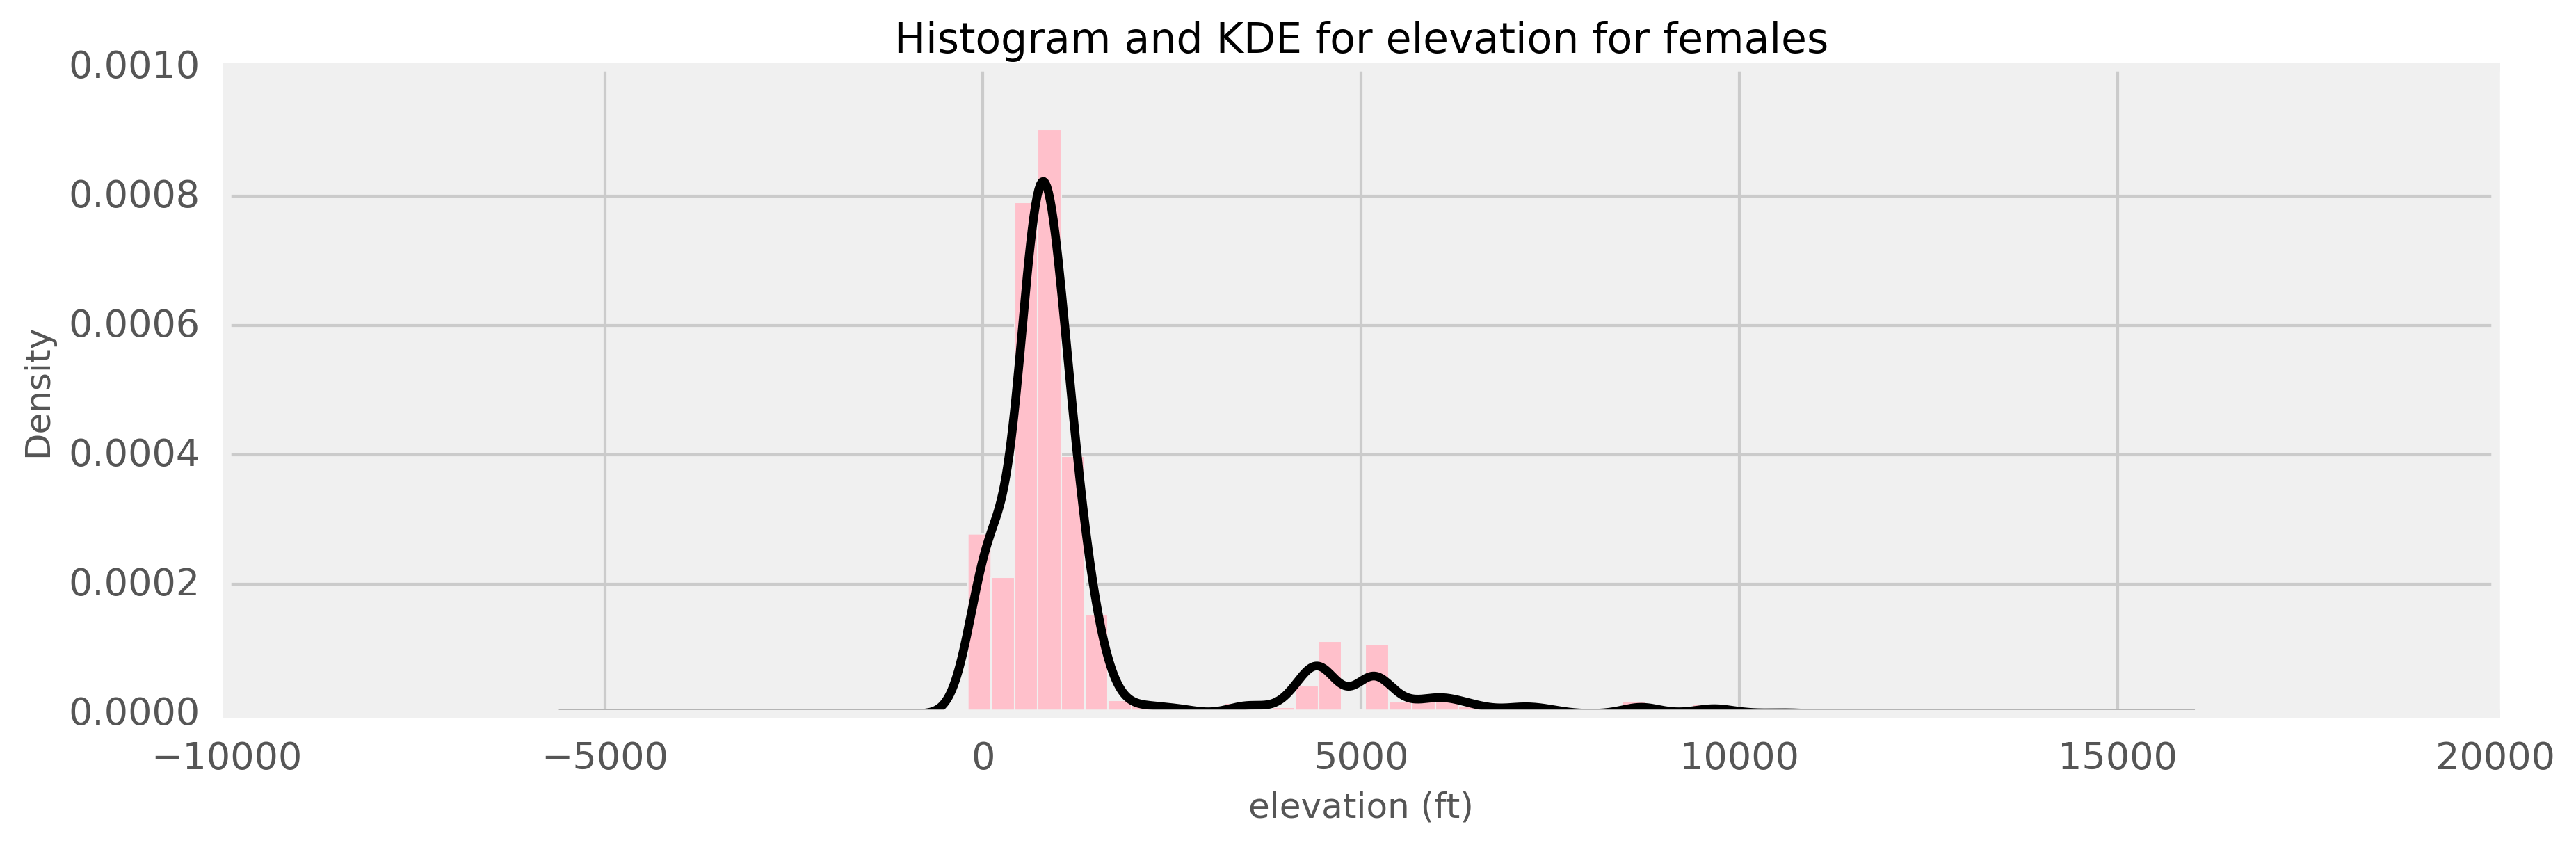

In [124]:
ax = dfsmall['elevation'][controlindices].hist(bins=35, color='Pink', normed=True)
dfsmall['elevation'][controlindices].plot(kind='kde',lw=3, color='Black', ax=ax)
plt.title('Histogram and KDE for elevation for females')
plt.xlabel('elevation (ft)');

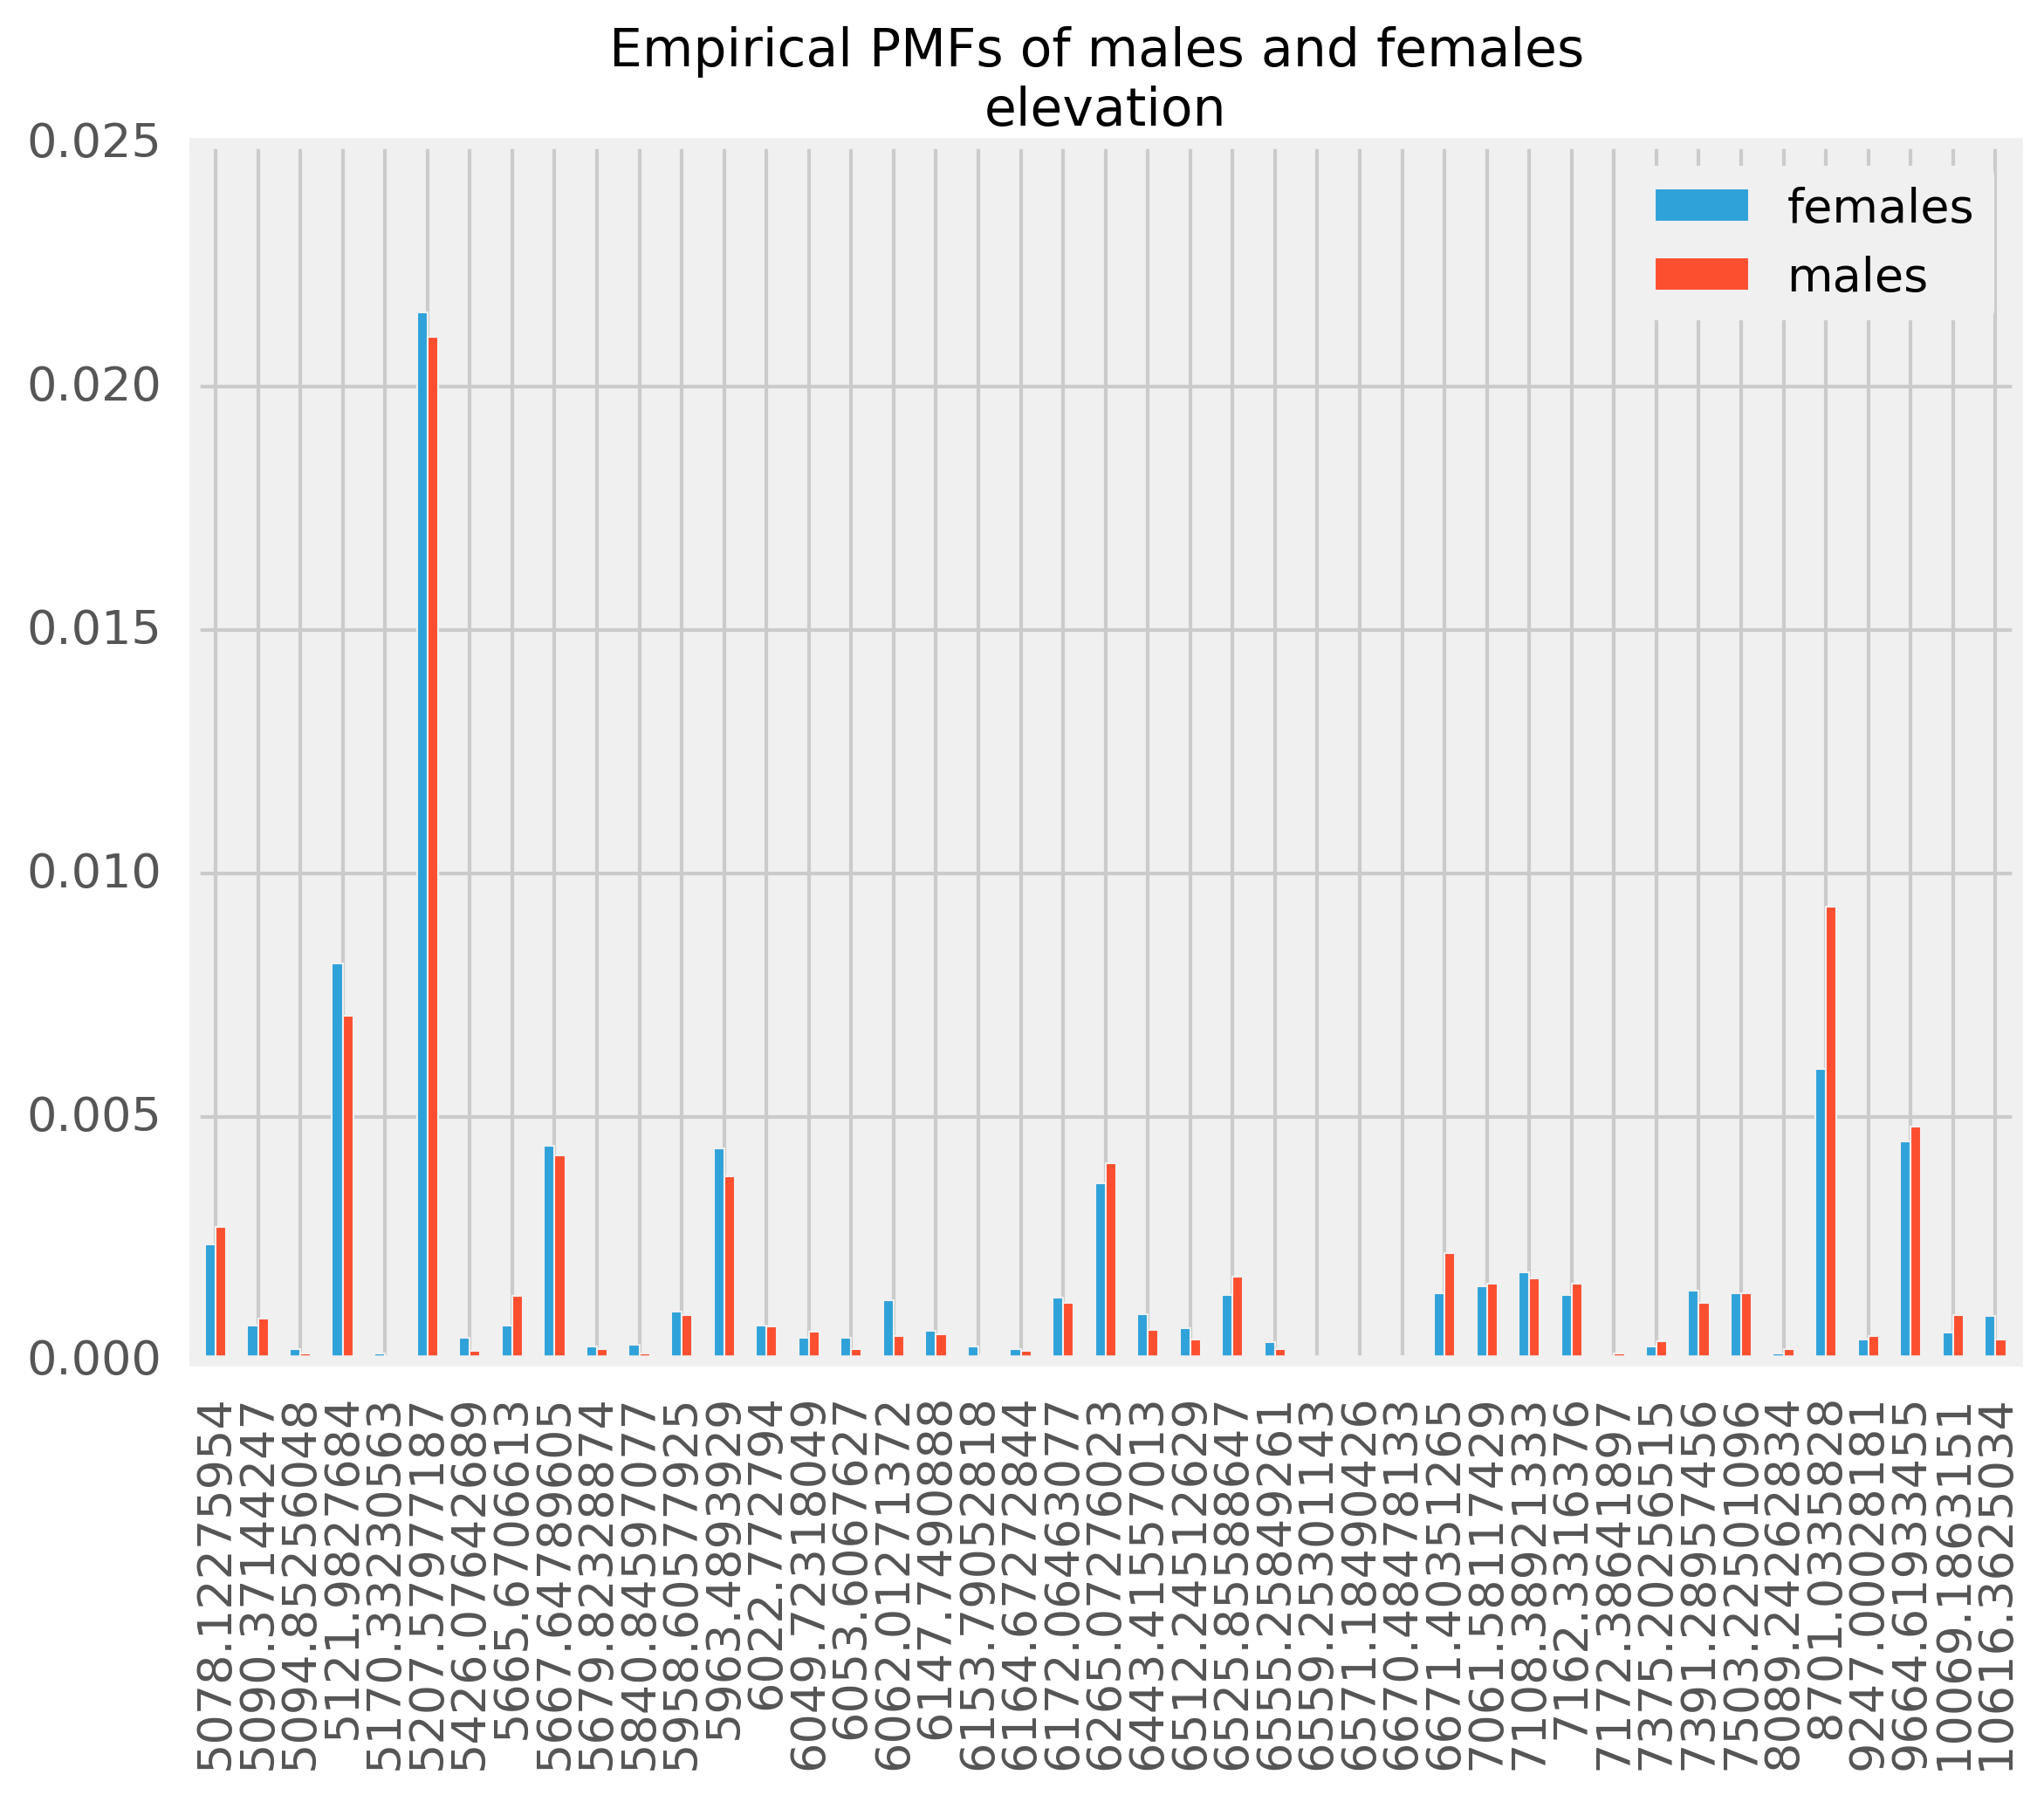

In [125]:
highpeople = (dfsmall['elevation'] >= 5000)

males_data = dfsmall['elevation'][highpeople][treatmentindices].value_counts(normalize=True).sort_index()
females_data = dfsmall['elevation'][highpeople][controlindices].value_counts(normalize=True).sort_index()

dfdata = pd.DataFrame({'males': males_data,
                      'females': females_data})
#dfdata = dfdata.fillna(method='ffill')
dfdata.plot(figsize=(8,6),kind='bar', title="Empirical PMFs of males and females \n" + 
           "elevation");

### <font color='purple'>The big spike at 8,701 feet where there are a lot more male colon cancer patients than female colon cancer patients is at lat 19.542915, lng 155.665857. It is Hawaii County, HI.</font>

In [126]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
#import basemap

In [127]:
dfsmall[['lat','lng']].head()

lat        lng
PUBCSNUM                      
7000298   41.326691 -72.804280
7000375   41.518519 -72.046816
7000588   41.469851 -72.473153
7000592   41.792434 -72.804280
7000642   41.792434 -72.804280

In [128]:
print(dfsmall['lat'].values[:6], dfsmall['lng'].values[:6])

[ 41.3266911  41.5185189  41.4698505  41.7924343  41.7924343  41.2559654] [-72.8042797 -72.0468164 -72.4731529 -72.8042797 -72.8042797 -73.3708696]


In [129]:
themap = Basemap(projection='gall',
              llcrnrlon = -15,              # lower-left corner longitude
              llcrnrlat = 28,               # lower-left corner latitude
              urcrnrlon = 45,               # upper-right corner longitude
              urcrnrlat = 73,               # upper-right corner latitude
              resolution = 'l',
              area_thresh = 100000.0,
              )

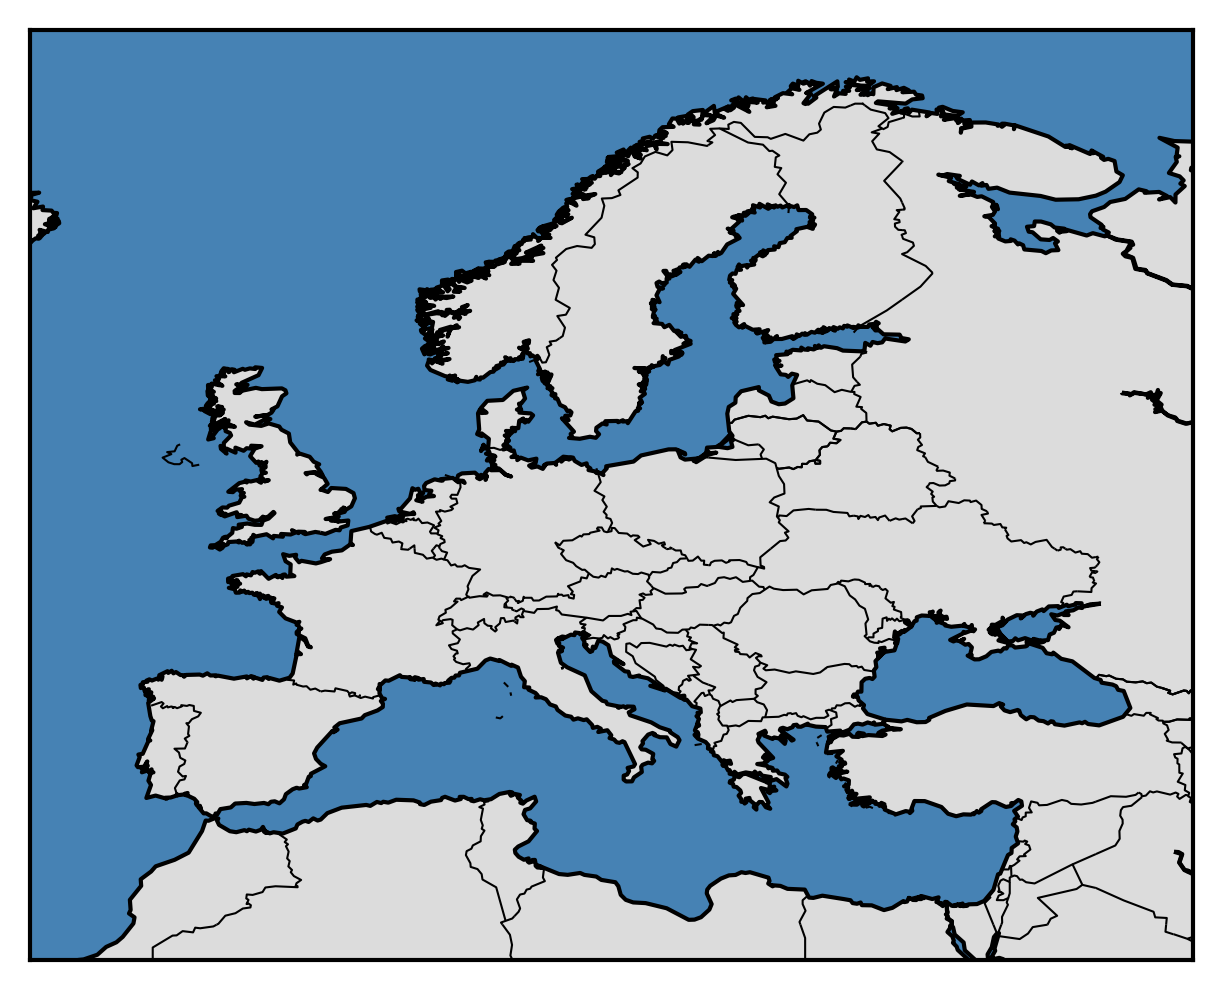

In [130]:
themap.drawcoastlines()
themap.drawcountries()
themap.fillcontinents(color = 'gainsboro')
themap.drawmapboundary(fill_color='steelblue')

In [131]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap as Basemap
from matplotlib.colors import rgb2hex
from matplotlib.patches import Polygon

# Lambert Conformal map of lower 48 states.
m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
            projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
# draw state boundaries.
# data from U.S Census Bureau
# http://www.census.gov/geo/www/cob/st2000.html
#shp_info = m.readshapefile('st99_d00','states',drawbounds=True)
shp_info = m.readshapefile('cb_2015_us_state_500k','states',drawbounds=True)
# population density by state from
# http://en.wikipedia.org/wiki/List_of_U.S._states_by_population_density
popdensity = {
'New Jersey':  438.00,
'Rhode Island':   387.35,
'Massachusetts':   312.68,
'Connecticut':	  271.40,
'Maryland':   209.23,
'New York':    155.18,
'Delaware':    154.87,
'Florida':     114.43,
'Ohio':	 107.05,
'Pennsylvania':	 105.80,
'Illinois':    86.27,
'California':  83.85,
'Hawaii':  72.83,
'Virginia':    69.03,
'Michigan':    67.55,
'Indiana':    65.46,
'North Carolina':  63.80,
'Georgia':     54.59,
'Tennessee':   53.29,
'New Hampshire':   53.20,
'South Carolina':  51.45,
'Louisiana':   39.61,
'Kentucky':   39.28,
'Wisconsin':  38.13,
'Washington':  34.20,
'Alabama':     33.84,
'Missouri':    31.36,
'Texas':   30.75,
'West Virginia':   29.00,
'Vermont':     25.41,
'Minnesota':  23.86,
'Mississippi':	 23.42,
'Iowa':	 20.22,
'Arkansas':    19.82,
'Oklahoma':    19.40,
'Arizona':     17.43,
'Colorado':    16.01,
'Maine':  15.95,
'Oregon':  13.76,
'Kansas':  12.69,
'Utah':	 10.50,
'Nebraska':    8.60,
'Nevada':  7.03,
'Idaho':   6.04,
'New Mexico':  5.79,
'South Dakota':	 3.84,
'North Dakota':	 3.59,
'Montana':     2.39,
'Wyoming':      1.96,
'Alaska':     0.42}
print(shp_info)
# choose a color for each state based on population density.
colors={}
statenames=[]
cmap = plt.cm.hot # use 'hot' colormap
vmin = 0; vmax = 450 # set range.
print(m.states_info[0].keys())
for shapedict in m.states_info:
    statename = shapedict['NAME']
    # skip DC and Puerto Rico.
    if statename not in ['District of Columbia','Puerto Rico','American Samoa',
                        'United States Virgin Islands','Guam',
                        'Commonwealth of the Northern Mariana Islands']:
        pop = popdensity[statename]
        # calling colormap with value between 0 and 1 returns
        # rgba value.  Invert color range (hot colors are high
        # population), take sqrt root to spread out colors more.
        colors[statename] = cmap(1.-np.sqrt((pop-vmin)/(vmax-vmin)))[:3]
    statenames.append(statename)
# cycle through state names, color each one.
ax = plt.gca() # get current axes instance
for nshape,seg in enumerate(m.states):
    # skip DC and Puerto Rico.
    if statenames[nshape] not in ['District of Columbia','Puerto Rico','American Samoa',
                                 'United States Virgin Islands','Guam',
                                 'Commonwealth of the Northern Mariana Islands']:
        color = rgb2hex(colors[statenames[nshape]]) 
        poly = Polygon(seg,facecolor=color,edgecolor=color)
        ax.add_patch(poly)
# draw meridians and parallels.
m.drawparallels(np.arange(25,65,20),labels=[1,0,0,0])
m.drawmeridians(np.arange(-120,-40,20),labels=[0,0,0,1])
plt.title('Filling State Polygons by Population Density')
plt.show()

(56, 5, [-179.148909, -14.548699, 0.0, 0.0], [179.77847, 71.365162, 0.0, 0.0], <matplotlib.collections.LineCollection object at 0x00000000530B62B0>)
dict_keys(['STATENS', 'STUSPS', 'LSAD', 'STATEFP', 'NAME', 'SHAPENUM', 'GEOID', 'AFFGEOID', 'AWATER', 'RINGNUM', 'ALAND'])


## <font color='purple'>Need to give myself a Basemap Tutorial!</font>

Basemap is a great tool for creating using python in a simple way. It's a matplotlib extension, so it has got all its features to create data visualizations, and adds the geographical projections and some datasets to be able to plot coast lines, countries, and so on directly from the library.

Basemap has got some documetntation, but some things are a bit more difificult to find. I started this documentation to extend a little the orignal documentation and examples, but it grew a little, and now covers many of hte basemap possibilities.

I started writing Basemap examples for a talk gtiven during the 2014 SIGTE meetings and I posted some examples in my blog (geoexamples.com). I would really appreciate some feedback if somebody finds an error, or thinks that some section should be added.

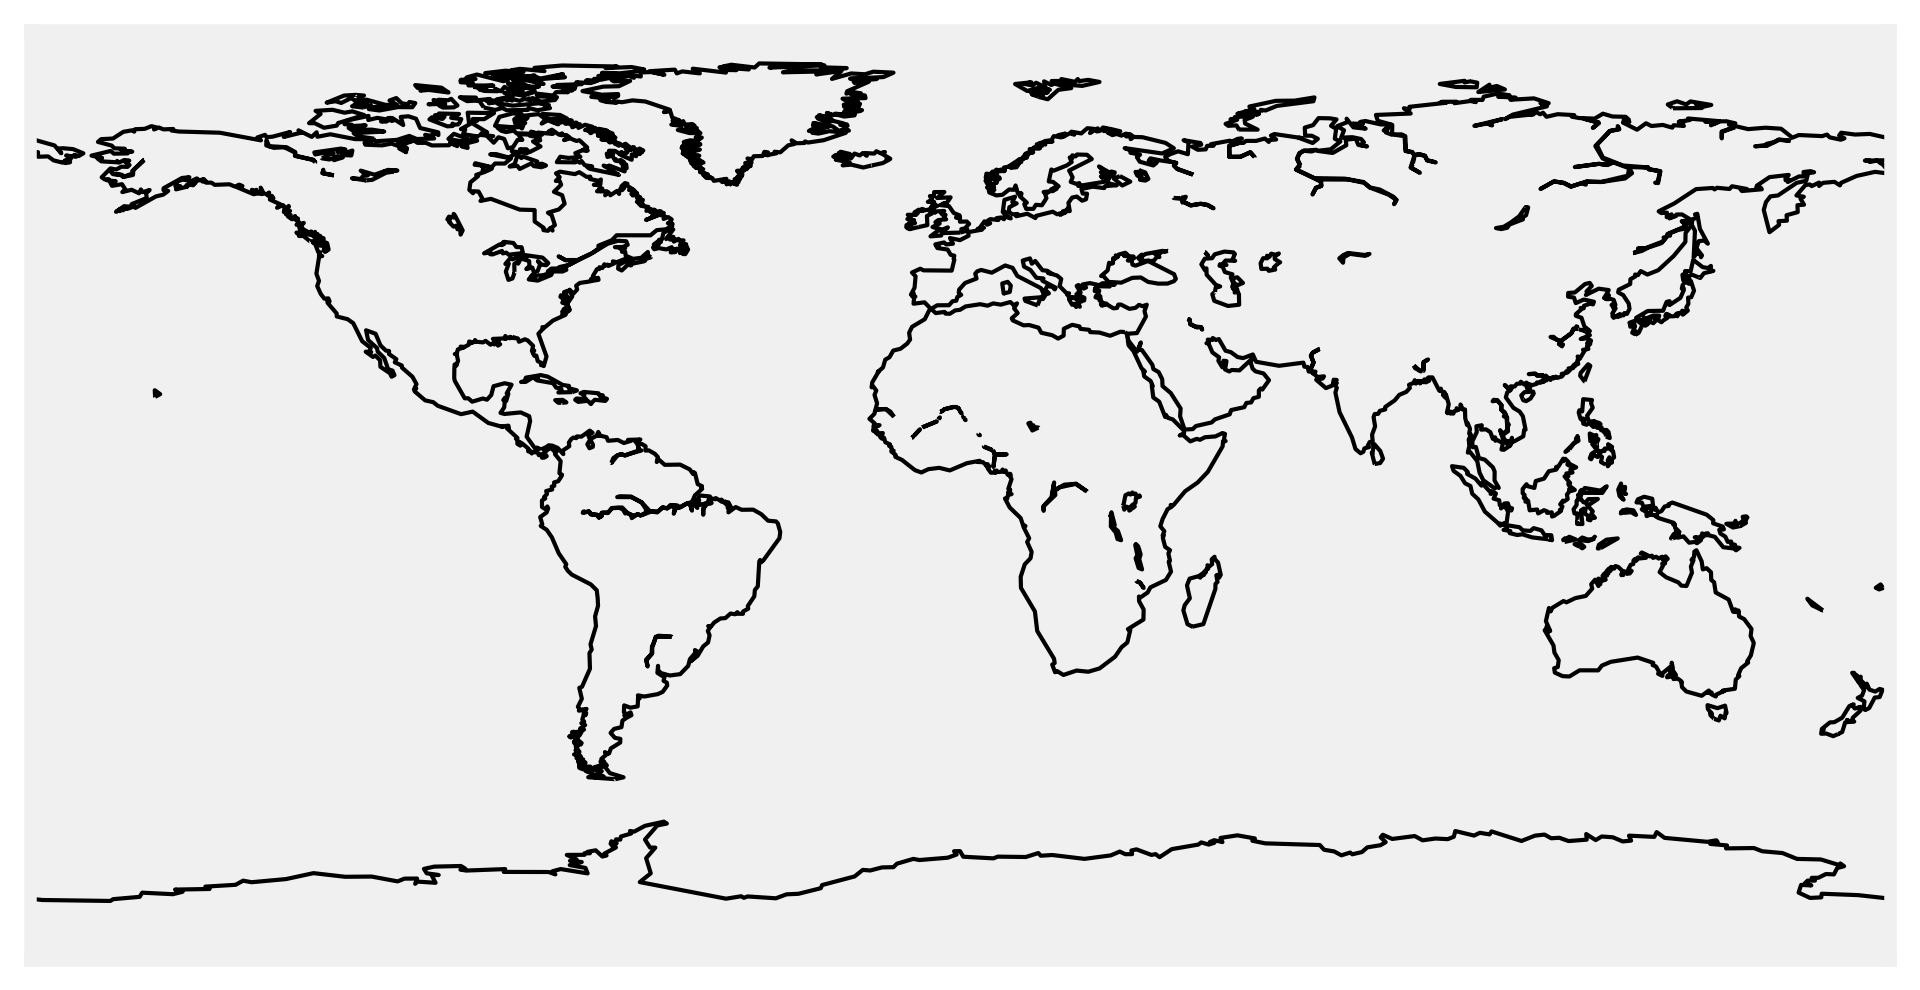

In [132]:
# Let's create the simplest map:

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

map = Basemap()

map.drawcoastlines();

plt.show();
plt.savefig('test.pdf');

Changing the projection is easy, just add the _projection_ arguement, and ```lat_0``` and ```lon_0``` to the Basemap constructor.
Even with the new projection, the map is still a bit poor, so let's fill the oceans and continents with some colors. The methods ```fillcontinents()``` and ```drawmapboundary()``` will do it.

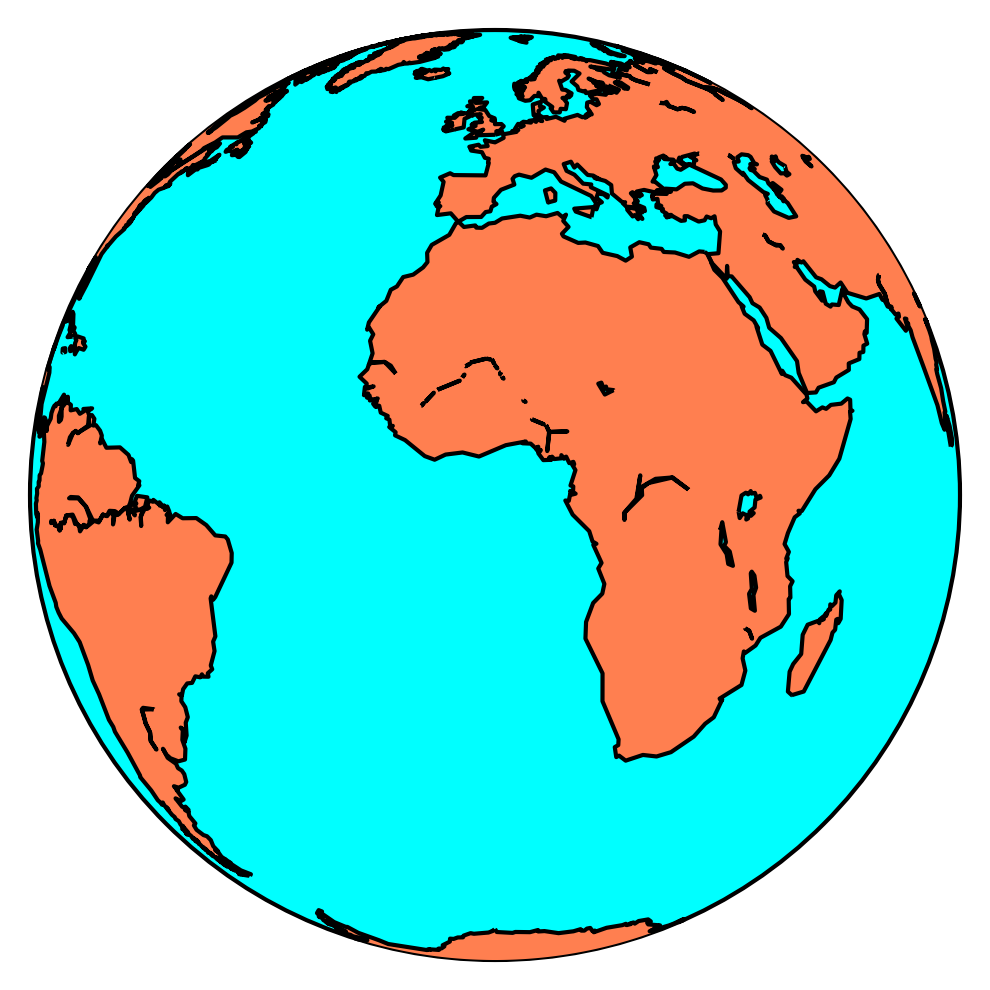

In [133]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

map = Basemap(projection='ortho', 
              lat_0=0, lon_0=0)

#Fill the globe with a blue color 
map.drawmapboundary(fill_color='aqua')
#Fill the continents with the land color
map.fillcontinents(color='coral',lake_color='aqua')

map.drawcoastlines()

plt.show()

In [134]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

map = Basemap(projection='cyl')

map.drawmapboundary(fill_color='aqua')
map.fillcontinents(color='coral',lake_color='aqua')
map.drawcoastlines()

plt.show()

In [135]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

map = Basemap(projection='aeqd', lon_0 = 10, lat_0 = 50)

map.drawmapboundary(fill_color='aqua')
map.fillcontinents(color='coral',lake_color='aqua')
map.drawcoastlines()

plt.show()

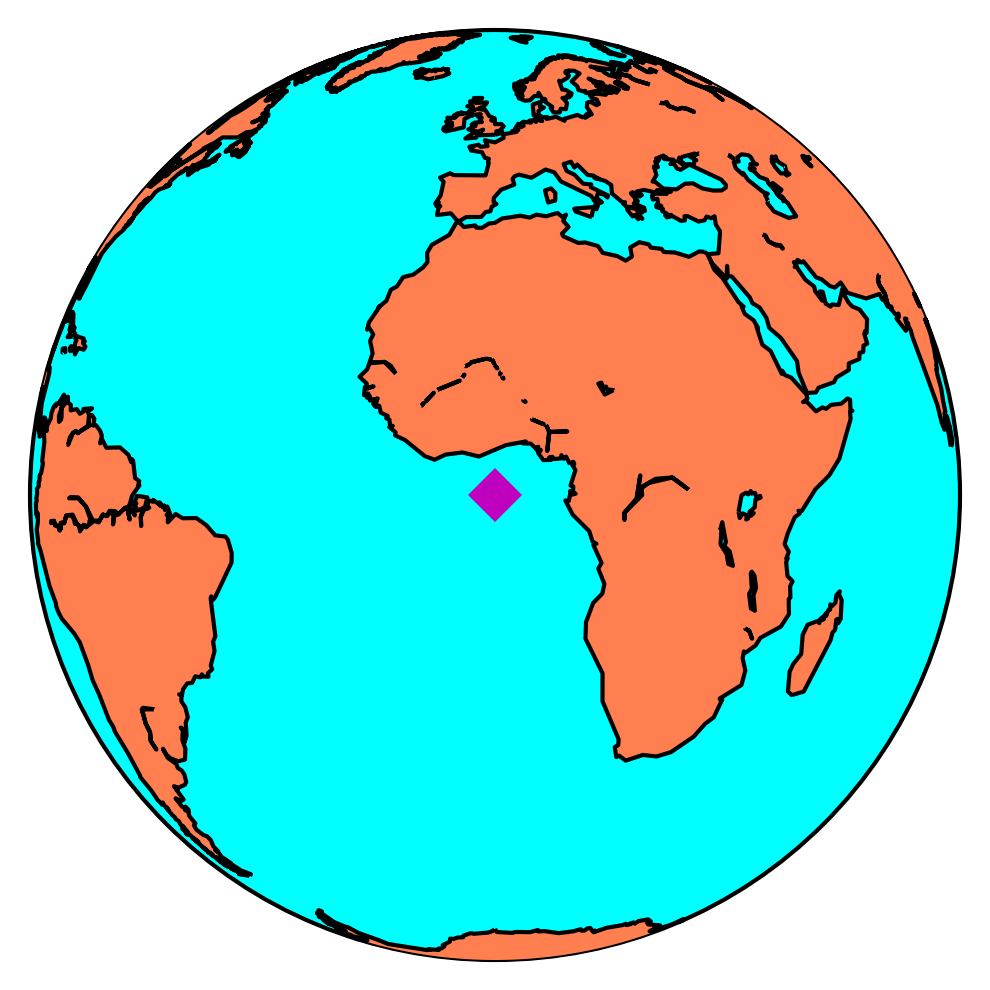

In [136]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

map = Basemap(projection='ortho', 
              lat_0=0, lon_0=0)

map.drawmapboundary(fill_color='aqua')
map.fillcontinents(color='coral',lake_color='aqua')
map.drawcoastlines()

x, y = map(0, 0)

map.plot(x, y, marker='D',color='m')

plt.show()

In [202]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

map = Basemap(projection='ortho', latlon=True,
              lat_0=32.16, lon_0=97.44)

map.drawmapboundary(fill_color='aqua')
map.fillcontinents(color='coral',lake_color='aqua')
map.drawcoastlines()

lons = [0, 10, -20, -20]
lats = [0, -10, 40, -20]

x, y = map(lons, lats)

map.scatter(x, y, marker='D',color='m')

plt.show()

TypeError: __init__() got an unexpected keyword argument 'latlon'